# Image captioning

**Task:** Implement a method to describe the contents of natural images in writing. Use the Flickr30k dataset.

Given an input image, we want to generate a sentence that describes the image. This multimodal problem combines the challenges of both computer vision and natural language processing. 

## Literature
As shown in this section, there has been a clear evolution in this field in recent years. Early methods used a combination of CNN and LSTMs. While CNNs tend to be replaced by region detection methods, LSTMs are replaced by Transformers. 

### Show and Tell: A Neural Image Caption Generator (2015)

https://arxiv.org/pdf/1411.4555.pdf

This paper came up with using CNNs for feature extraction followed by LSTM RNNs for caption generation.

<img src="assets/show,tell.png" width="30%;">


### Show, Attend and Tell: Neural Image Caption Generation with Visual Attention (2016)

https://arxiv.org/pdf/1502.03044v3.pdf

Here, the authors upgraded the previous solution by introducing attention for recognizing salient parts of the image. This popular paper is also the reason why attention has become the basis of all state-of-the-art image captioning solutions.

<img src="assets/show,attend,tell.png" width="40%;">


### Captioning Transformer with Stacked Attention Modules (2018)

https://www.mdpi.com/2076-3417/8/5/739

With the success of the transformer architecture in text analysis and translation, this paper replaces the so-far used LSTMS as decoders by the Transformer, naming it the Caption Transformer. This brought the benefits of higher troughput in training thanks to parallelization, which is not possible in RNNs.

<img src="assets/stacked_attention.png" width="30%;">


### Image Captioning through Image Transformer (2020)

https://arxiv.org/pdf/2004.14231v2.pdf

This paper aims at utilizing the semantic units in images by first detecting objects using Faster R-CNN and then using the Transformer for refinement and decoding as shown below.

<img src="assets/ImageCaptioningThroughTransformer.png" width="50%;">


### CPTR: Full Transformer Network for Image Captioning (2021)

https://arxiv.org/pdf/2101.10804.pdf

With the introduction of the [Vision Transformer (ViT)](https://arxiv.org/pdf/2010.11929.pdf), it considers the task to be a sequence-to-sequence task as opposed to the previously mentioned CNN+Transformer approaches. This allows it to model global context at every encoder layer, addressing the vanishing gradients problem, providing higher throughput and giving better prediction scores. This paper is the main reference for this project.

<img src="assets/CPTR_schema.png" width="60%;">


### End-to-End Transformer Based Model for Image Captioning (2022)

https://arxiv.org/pdf/2203.15350v1.pdf

An example of a more recent end-to-end transformer approach, but using the SwinTransformer as the backbone encoder to extract grid-level features from images instead of simple splitting into patches as seen in CPTR.

I was also considering to implement method, but due to the use of these special modules, I have concluded that it would be too hard to implement.

<img src="assets/swin.png" width="70%;">

### Sources

Since this problem has been addressed in so many different ways, it was difficult to find a resource to get direct inspiration from. As a result, my solution is a mixture of all of the sources below. All tutorials listed below differ in the way they are implemented, even diverge from the paper, which led to a lot of confusion during my work on this project.

 - [The CPTR paper](https://arxiv.org/pdf/2101.10804.pdf) as the reference model architecture for this project.
 - [Tensorflow Image Captioning Tutorial](https://www.tensorflow.org/tutorials/text/image_captioning)
   - Uses MobileNetV3Small for image feature extraction.
   - Implemented in Keras.
   - Has been of great help mainly in the text processing part, where I have little knowledge of.
 - https://python.plainenglish.io/image-captioning-with-an-end-to-end-transformer-network-8f39e1438cd4
   - Implements the CPTR paper in Keras
 - [github.com/milkymap/transformer-image-captioning](https://github.com/milkymap/transformer-image-captioning)
   - Even though it is an implementation of the CPTR paper, at the same time, it is also a web application, making it harder to understand and debug the code.
 - [PyTorch Transformer tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)
   - Working with PyTorch text functions.

## Initialization

In [116]:
%load_ext autoreload
%autoreload 2

import torch

#dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from torch import nn, Tensor
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
import torchtext
import math
from random import randint
from einops import rearrange
import torch.optim as optim

In [118]:
config_reference = {
    'name' : 'Flickr30k',
    'batch_size' : 16,
    'image_size' : 224, #384
    'patch_size' : 16,
    'channels'   : 3,
    'dim' : 768,
    'dim_mlp': 768,
    'num_layers' : 12,
    'nhead' : 12,
    'vocab_size': 5000,
    'seq_length': 50,
    'lr': 0.00003,
    'epochs': 5,
    'dropout': 0.1,
}

config = {
    'name' : 'Flickr30k',
    'batch_size' : 16,
    'image_size' : 224, #384
    'patch_size' : 16,
    'channels'   : 3,
    'dim' : 768,
    'dim_mlp': 768,
    'num_layers' : 4,
    'nhead' : 4,
    'vocab_size': 5000,
    'seq_length': 50,
    'lr': 0.001,
    'epochs': 2,
    'dropout': 0.1,
}

## Dataset

Download the dataset from here: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

Extract it to the path given by `IMAGES_PATH` and `CAPTIONS_PATH` below.

In [119]:
IMAGES_PATH = "./data/Flickr30k/flickr30k_images/"
CAPTIONS_PATH = "./data/Flickr30k/results.csv"

df = pd.read_csv(CAPTIONS_PATH, delimiter="\| ", engine='python').dropna(how='any', axis=0)
print(df.head())

# Filter out too long captions
df['word_count'] = list(map(lambda x: len(x.split(' ')), df["comment"]))
df = df[df['word_count'] <= config['seq_length']]

imgs, captions = df["image_name"].to_numpy(), df["comment"].to_numpy()
print()
print("Dataset size:", len(imgs))

       image_name comment_number   
0  1000092795.jpg              0  \
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  
0  Two young guys with shaggy hair look at their ...  
1  Two young , White males are outside near many ...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  

Dataset size: 158823


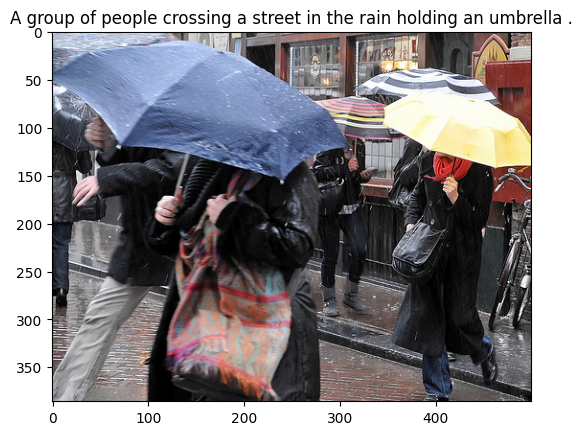

In [120]:
def show_sample_Flickr(imgs, captions, idx):
	img_path, caption = imgs[idx], captions[idx]
	img = io.imread(IMAGES_PATH + img_path)

	fig, ax = plt.subplots()

	ax.imshow(img)
	ax.set_title(caption)
	plt.show()

show_sample_Flickr(imgs, captions, randint(0, len(imgs)-1))

### Text preprocessing

First, we need to tokenize the sentences, i.e., to convert the sentence strings to arrays of standardized words (e.g., lowercase, words in their base form). In addition, we add special symbols `<bos>` and `<eos>`, representing the beginning and the end of the caption, respectively.

Next, we build a vocabulary from these tokens. It serves as a lookup from words to indices, since the neural network works with numbers, not strings. We set a maximum size to the vocabulary, usually 5000, which means that only the 5000 most frequent words will be in the present vocabulary. If we query an unknown word, the vocabulary will return a special symbol `<unk>`.

In [121]:
class Tokenizer():
    def __init__(self):
        self.tokenizer = get_tokenizer('basic_english')
    
    def tokenize_captions(self, captions: list[str]) -> list[list[str]]:
        return [[Vocabulary.bos] + self.tokenizer(caption) + [Vocabulary.eos] for caption in captions if caption is not None]


class Vocabulary(nn.Module):
    unk = "<unk>"
    pad = "<pad>"
    bos = "<bos>"
    eos = "<eos>"
    specials2idx = {unk: 0, pad: 1, bos: 2, eos: 3}
    
    def __init__(self, captions_tok, max_tokens):
        super(Vocabulary, self).__init__()
        
        self.vocab = build_vocab_from_iterator(
            iterator=captions_tok, 
            specials=Vocabulary.specials2idx.keys(), 
            special_first=True, 
            max_tokens=max_tokens
        )
        self.vocab.set_default_index(self.vocab[Vocabulary.unk])
        
    def forward(self, caption_tok: list[str]) -> list[int]:
        return self.vocab(caption_tok)
    
    def __getitem__(self, token: str) -> int:
        return self.vocab[token]
    
    def lookup_tokens(self, tokens: list[int]) -> list[str]:
        return self.vocab.lookup_tokens(tokens.squeeze(0).tolist())
    
    def join_tokens(self, tokens: list[int]) -> str:
        caption_tok = self.lookup_tokens(tokens)
        return " ".join(caption_tok)
    
    def padding_idx(self):
        return self.vocab[Vocabulary.pad]

In [122]:
tokenizer = Tokenizer()
captions_tok = tokenizer.tokenize_captions(captions)
vocab = Vocabulary(captions_tok, config['vocab_size'])

i = 3
print("Caption:", captions[i])
print("Caption tokenized:", captions_tok[i])
print("Caption numericalized:", vocab(captions_tok[i]))
print("Caption restored:", vocab.join_tokens(torch.IntTensor(vocab(captions_tok[i]))))

Caption: A man in a blue shirt standing in a garden .
Caption tokenized: ['<bos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'in', 'a', 'garden', '.', '<eos>']
Caption numericalized: [2, 4, 10, 6, 4, 29, 25, 35, 6, 4, 714, 5, 3]
Caption restored: <bos> a man in a blue shirt standing in a garden . <eos>


### Train-test split

In [123]:
ratio = 0.972
temp_x, test_x, temp_y, test_y = train_test_split(imgs, captions_tok, test_size=ratio, random_state=10)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=ratio, random_state=20)

print("Lenght of Training set: ", len(train_x))
print("Lenght of Validation set: ", len(valid_x))
print("Lenght of Test set: ", len(test_x))

Lenght of Training set:  124
Lenght of Validation set:  4323
Lenght of Test set:  154376


### Flickr30k Dataset

When creating the data loader for our dataset, we need to implement padding of the captions to a specified length. Is it because we need to unify the lengths of captions within a training batch. Padding a sentence to a given length means appending a special token `<pad>` as many times as it is needed to reach the specified length.

The output of the dataloader is a tuple of the input and the output of the model. The input consists of the image and the image caption. The output is only the image caption, but **shifted to the left by 1**.

In [124]:
class Flickr30kDataset(Dataset):
    def __init__(self, img_paths, captions_tok, img_transforms, caption_transforms, base_path=IMAGES_PATH):
        self.img_paths = img_paths
        self.captions_tok = captions_tok
        self.img_transforms = img_transforms
        self.caption_transforms = caption_transforms
        self.base_path = base_path
        
    def __getitem__(self, index):
        # Image
        img_path = self.img_paths[index]
        img = io.imread(self.base_path + img_path)
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        
        # Caption
        caption_tok = self.captions_tok[index]
        if self.caption_transforms is not None:
            caption_tok = self.caption_transforms(caption_tok)
            
        return img, caption_tok
            
    def __len__(self):
        return len(self.img_paths)
    
    
class Flickr30kCollate:
    def __init__(self, pad_idx, total_len=None):
        """Collate function for Flickr30k dataset.

        Args:
            pad_idx (int): Index of the <pad> token.
            total_len (_type_): The length to pad the sequences with the <pad> token. 
                                If None, the sequences will be padded to the batch size.
        """
        self.pad_idx = pad_idx
        self.max_len = total_len
        
    def pad_caption(self, caption):
        return nn.ConstantPad1d((0, self.max_len - len(caption)), self.pad_idx)(caption)

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        captions = [item[1] for item in batch]
        
        # create the target caption, shift it to left by one
        captions_tok_target = [caption[1:] for caption in captions]
        captions_tok = [caption[:-1] for caption in captions]
        
        # pad captions
        if self.max_len is not None:
            captions_tok[0] = self.pad_caption(captions_tok[0])
        captions_tok = pad_sequence(captions_tok, batch_first=True, padding_value=self.pad_idx)
         
        if self.max_len is not None:
            captions_tok_target[0] = self.pad_caption(captions_tok_target[0])
        captions_tok_target = pad_sequence(captions_tok_target, batch_first=True, padding_value=self.pad_idx)
        
        return (imgs.to(dev), captions_tok.to(dev)), captions_tok_target.to(dev)

#### Augmentations

In [125]:
transforms_img_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((config['image_size'], config['image_size']), antialias=True),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

transforms_img_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((config['image_size'], config['image_size']), antialias=True),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

caption_transforms = torchtext.transforms.Sequential(
    vocab,
    torchtext.transforms.ToTensor()
)

#### Dataloader

In [126]:
collate_fn = Flickr30kCollate(pad_idx=vocab.padding_idx())

train_ds = Flickr30kDataset(train_x, train_y, transforms_img_train, caption_transforms)
valid_ds = Flickr30kDataset(valid_x, valid_y, transforms_img_valid, caption_transforms)

train_dl = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_fn)

for batch in train_dl:
    (imgs, captions), captions_target = batch
    
    img = imgs[0]
    caption_tok = captions[0]
    caption_target = captions_target[0]
    print("Image shape:", img.shape)
    print("Input caption:", caption_tok)
    print("Target caption:", caption_target) # target shifted to left by one
    break

Image shape: torch.Size([3, 224, 224])
Input caption: tensor([   2,   16,  736,  118,  246,  218, 4597,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1])
Target caption: tensor([  16,  736,  118,  246,  218, 4597,    3,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1])


## The Model: CPTR

The encoder is the same as in ViT. The image is first split into patches, each patch is embedded to latent space of the Transformer input, but before feeding it into the Transformer, a learnable 1D position embedding is added to the patch features.

<img src="./assets/CPTR_schema.png" alt="CPTR Schema" style="width: 50%;"/>

### CPTR Encoder

<img src="./assets/CPTR_encoder.png" alt="CPTR Schema" style="width: 20%;"/>

In [127]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, dim, nhead, hidden_dim, dropout):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        
        self.toqueries = nn.Linear(dim, dim, bias=False)
        self.tokeys = nn.Linear(dim, dim, bias=False)
        self.tovalues = nn.Linear(dim, dim, bias=False)
        
        self.self_attention = nn.MultiheadAttention(dim, nhead, dropout)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim)
        )
        
        self.att_map = None
        
    def forward(self, x):
        q = self.toqueries(x)
        k = self.tokeys(x)
        v = self.tovalues(x)
        
        x_res = x
        x, attention_map = self.self_attention(q, k, v)
        x += x_res
        x = self.norm1(x)
        x_res = x
        x = self.mlp(x)
        x += x_res
        x = self.norm2(x)
        
        self.att_map = attention_map
        
        return x

In [128]:
class TransformerEncoder(nn.Module):
    def __init__(self, dim, num_layers, nhead, dim_mlp, dropout):
        super().__init__()

        self.layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.layers.append(TransformerEncoderLayer(dim, nhead, dim_mlp, dropout))

    def forward(self, x):
        for tb in self.layers:
            x = tb(x)
        return x
    
    def get_attention_maps(self, x):
        self(x)
        return [tb.att_map for tb in self.layers]

In [129]:
class CPTREncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        image_size = config['image_size']
        patch_size = config['patch_size']
        channels = config['channels']
        dim = config['dim']
        num_layers = config['num_layers']
        nhead = config['nhead']
        dim_mlp = config['dim_mlp']
        dropout = config['dropout']
        
        # validate setting of attributes
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        self.patch_size = patch_size
        
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
            
        self.transformer_encoder = TransformerEncoder(dim, num_layers, nhead, dim_mlp, dropout)
        
    def prepare_img(self, img):
        p = self.patch_size
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)
        return x + self.pos_embedding
        
    def forward(self, img):
        x = self.prepare_img(img)
        x = self.transformer_encoder(x)
        
        return x
    
    def get_attention_maps(self, img):
        x = self.prepare_img(img)
        return self.transformer_encoder.get_attention_maps(x)
    
encoder = CPTREncoder(config)
encoder

CPTREncoder(
  (patch_to_embedding): Linear(in_features=768, out_features=768, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (toqueries): Linear(in_features=768, out_features=768, bias=False)
        (tokeys): Linear(in_features=768, out_features=768, bias=False)
        (tovalues): Linear(in_features=768, out_features=768, bias=False)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=768, out_features=768, bias=True)
        )
      )
    )
  )
)

#### Using the ViT encoder

In fact, it is advantageous to use the pretrained ViT encoder to speed up learning and to achieve better results.

<img src="assets/ablation.png" width="40%;">

In [130]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

class ViTEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        dim = config['dim']
        self.seq_length = config['seq_length']
        
        self.weights = ViT_B_16_Weights.DEFAULT
        self.model = vit_b_16(weights=self.weights)
        # freeze the model parameters
        for param in self.model.parameters():
            param.requires_grad_(False)
        
        self.model.heads = nn.Identity()#nn.Linear(dim, dim)
        self.preprocess_img = self.weights.transforms()
    
    def forward(self, x):
        x = self.preprocess_img(x)
        x = self.model(x)
        return x.unsqueeze(1) # use to get output of size (batch_size, 1, dim)
        return x.repeat(x, 'm n -> m k n', k=self.seq_length) # use to get output of size (batch_size, seq_length, dim)
    
vitEncoder = ViTEncoder(config)
vitEncoder


ViTEncoder(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): Laye

### CPTR Decoder

For the decoder part, we will not use a pretrained model. Here, we first embed the caption tokens, then we add sinusoid positional embedding and feed it, together with the result from the encoder, to the Decoder block.

The Decoder block contains a masked multi-head self-attention sublayer, followed by a multi-head cross attention sublayer and a feed-forward sublayer sequentially.

After the last Decoder block, there is a MLP mapping it to the output dimension `(batch_size, input_sequence_length, vocabulary_size)` to predict the next word.

<img src="./assets/CPTR_decoder.png" alt="CPTR Schema" style="width: 20%;"/>

In [131]:
# Source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[0, :x.size(1)]
        return self.dropout(x)
    
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of ``-inf``, with zeros on ``diag``."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    
def build_key_padding_mask(seq, pad_idx):
    seq_key_padding_mask = (seq == pad_idx)
    return seq_key_padding_mask

In [132]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, dim, nhead, hidden_dim, dropout):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)
        
        self.tokeys_self = nn.Linear(dim, dim, bias=False)
        self.toqueries_self = nn.Linear(dim, dim, bias=False)
        self.tovalues_self = nn.Linear(dim, dim, bias=False)
        
        self.tokeys_cross = nn.Linear(dim, dim, bias=False)
        self.toqueries_cross = nn.Linear(dim, dim, bias=False)
        self.tovalues_cross = nn.Linear(dim, dim, bias=False)
    
        self.masked_self_attention = nn.MultiheadAttention(dim, nhead, dropout=dropout, batch_first=True)
        self.cross_attention = nn.MultiheadAttention(dim, nhead, dropout=dropout, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim)
        )
        
    def forward(self, x, encoded_img, attn_mask, key_padding_mask):
        # x: (batch_size, seq_length, dim)
        
        q = self.toqueries_self(x)
        k = self.tokeys_self(x)
        v = self.tovalues_self(x)
        
        # Masked Self-Attention + Add & Layer Norm
        x_res = x
        #x, _ = self.masked_self_attention(q, k, v, attn_mask=attn_mask, key_padding_mask=key_padding_mask, need_weights=False)
        x, _ = self.masked_self_attention(q, k, v, need_weights=False, is_causal=True)
        x += x_res
        x = self.norm1(x)
        
        # Cross Attention + Add & Layer Norm
        q = self.toqueries_cross(x)
        k = self.tokeys_cross(encoded_img)
        v = self.tovalues_cross(encoded_img)
        
        x_res = x
        x, _ = self.cross_attention(q, k, v, need_weights=False)
        x += x_res
        x = self.norm2(x)
        
        x_res = x
        x = self.mlp(x)
        x += x_res
        x = self.norm3(x)
        
        return x

In [133]:
class TransformerDecoder(nn.Module):
    def __init__(self, dim, num_layers, nhead, dim_mlp, dropout):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.layers.append(TransformerDecoderLayer(dim, nhead, dim_mlp, dropout))

    def forward(self, x, encoded_img, attn_mask, key_padding_mask):
        for tb in self.layers:
            x = tb(x, encoded_img, attn_mask, key_padding_mask)
        return x
    
    def get_attention_maps(self, x):
        # returns attention maps
        self(x)
        # return list of attention maps
        return [tb.att_map for tb in self.layers]

In [134]:
class CPTRDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        dim = config['dim']
        num_layers = config['num_layers']
        nhead = config['nhead']
        dim_mlp = config['dim_mlp']
        dropout = config['dropout']
        vocab_size = config['vocab_size']
        seq_length = config['seq_length']
        
        self.embedding_scale = np.sqrt(dim)
        self.word_embedding = nn.Embedding(vocab_size, dim, vocab.padding_idx())
        
        self.transformer_decoder = TransformerDecoder(dim, num_layers, nhead, dim_mlp, dropout)
        self.linear = nn.Linear(dim, vocab_size)
        
        self.pos_encoding = PositionalEncoding(dim, dropout, max_len=seq_length)
        self.softmax = nn.Softmax()
        
    def forward(self, x, encoded_img):
        key_padding_mask = build_key_padding_mask(x, vocab.padding_idx())
        attn_mask = generate_square_subsequent_mask(x.shape[1])
        
        x = self.word_embedding(x)
        x = self.pos_encoding(x) * self.embedding_scale
        x = self.transformer_decoder(x, encoded_img, attn_mask, key_padding_mask)
        x = self.linear(x)
        return self.softmax(x)

### CPTR Model

The final model consits of the encoder and the decoder.

To generate a captions, we start with an initial start token: `[<bos>]`. We encode the image and feed it together with the token into the decoder, which predicts an output of the same size as the input, in this case 1. We concatenate this word with the initial token and feed the encoded image with these two tokens to obtain a new token, which is always the last token of the decoder output.

In [135]:
class CPTR(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        #self.encoder = CPTREncoder(config) # from scratch
        self.encoder = ViTEncoder(config) # pretrained
        self.decoder = CPTRDecoder(config)
        
    def forward(self, imgs, captions):
        encoded_imgs = self.encoder(imgs)
        return self.decoder(captions, encoded_imgs)
    
    def simple_gen(self, img_batch):
        initial = torch.IntTensor([vocab[Vocabulary.bos]]*len(img_batch)).unsqueeze(1) # [['<bos>'], ['<bos>'], ..., ['<bos>']]
        img_encoded = self.encoder(img_batch)
        
        tokens = initial
        for n in range(config['seq_length']):
            preds = self.decoder(tokens, img_encoded) #(batch, in_sequence, vocab)
            
            # we are interested in the latest predicted word, so take the last one
            preds = preds[:, -1, :] #(batch, vocab)
            
            # find the word index with the highest probability
            next = torch.argmax(preds, dim=-1).unsqueeze(1)
            
            # append it to the sentence
            tokens = torch.cat([tokens, next], dim=1)
            
            # if the latest predicted word is '<eos>', we are done
            if next[0] == vocab[Vocabulary.eos]:
                break
        
        # generate strings
        result = [vocab.join_tokens(batch_tokens[1:-1]) for batch_tokens in tokens]
        return result
    
model = CPTR(config).to(dev)

#### Generate captions with an untrained model

As you might have expected, just gibberish.

c:\Source\Repos\PA228-ml\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\attil\AppData\Local\Temp\ipykernel_26912\2919743234.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


torch.Size([16, 19, 5000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


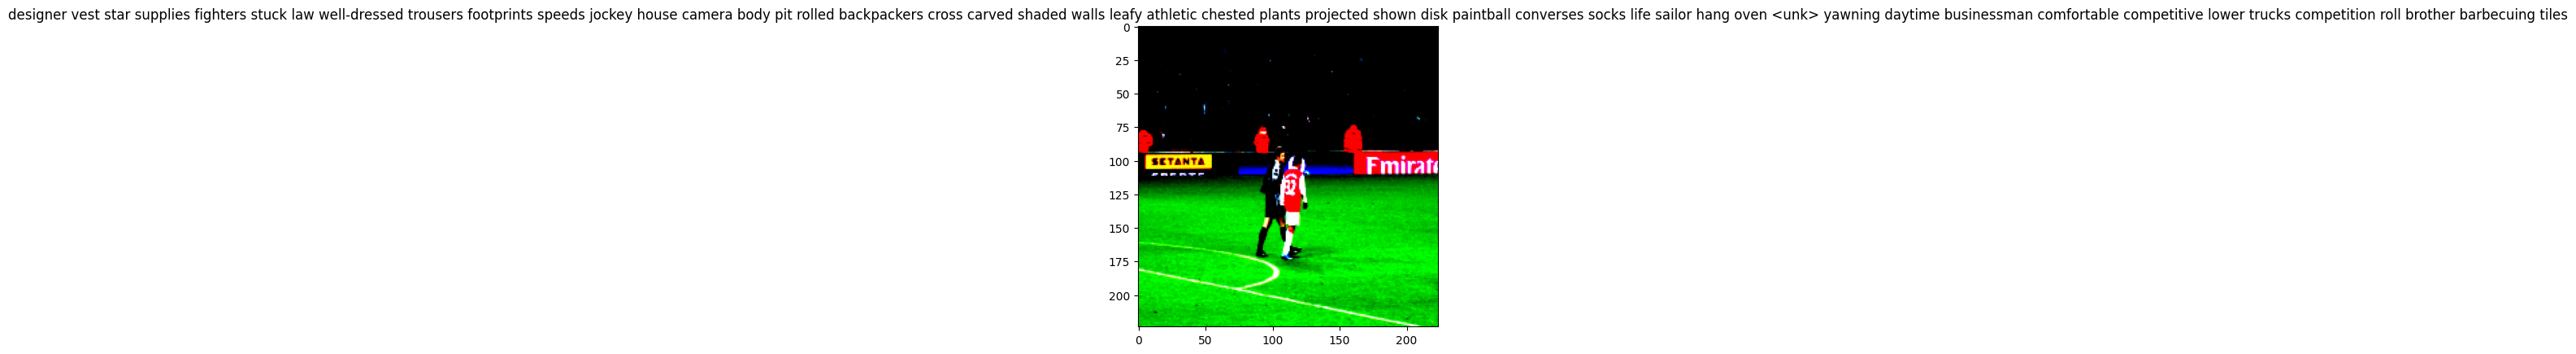

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


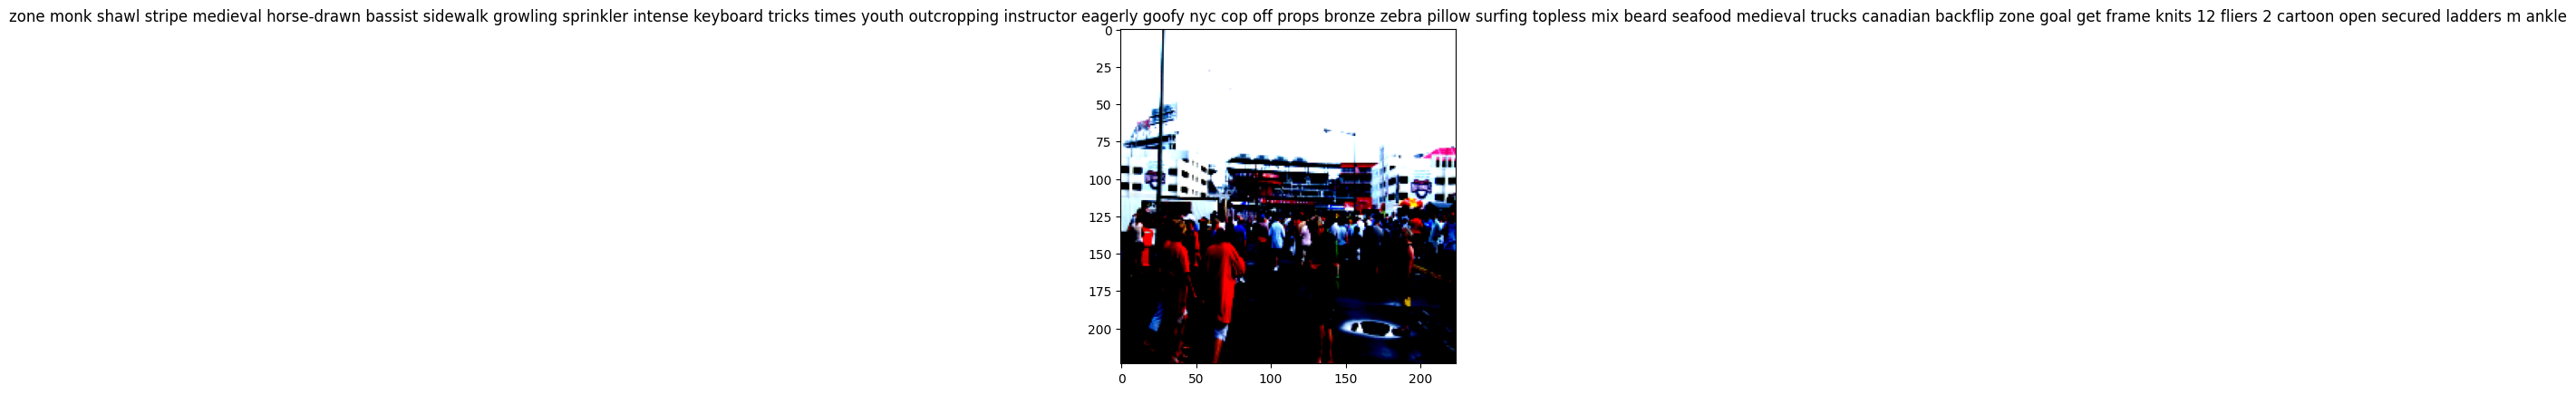

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


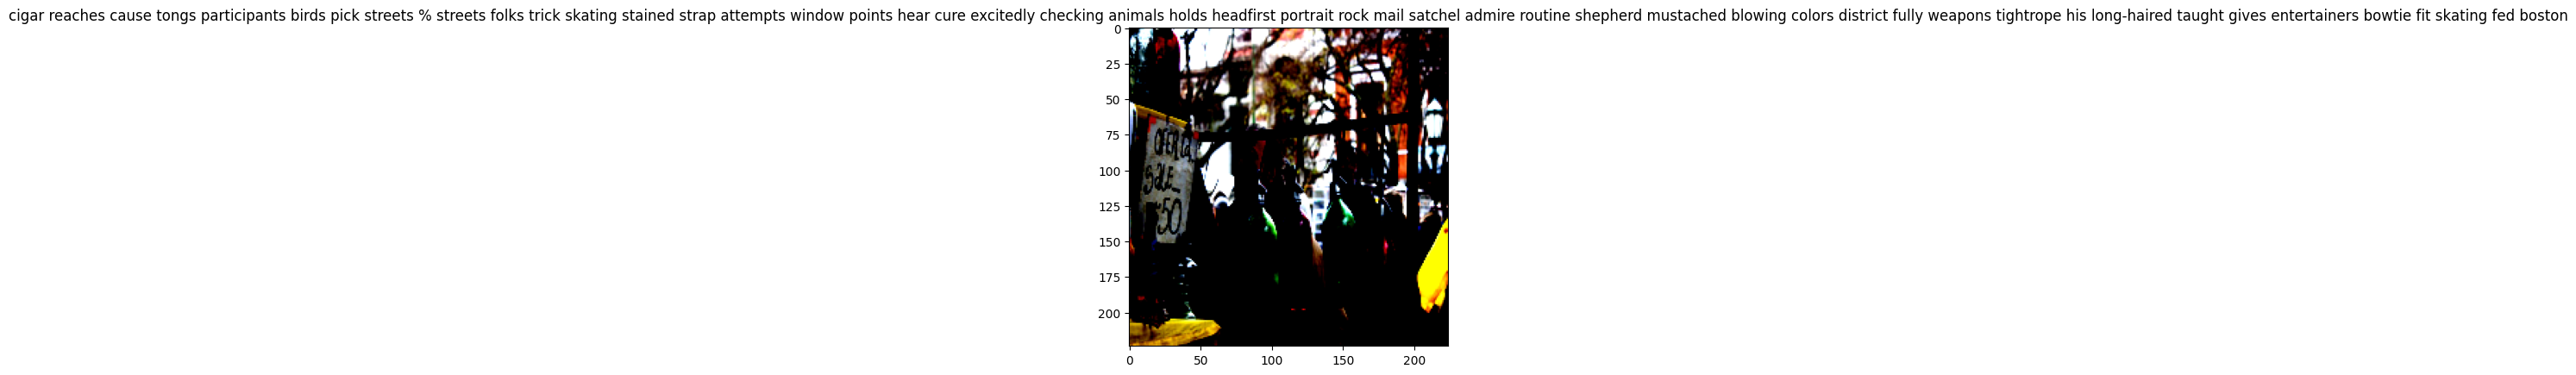

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


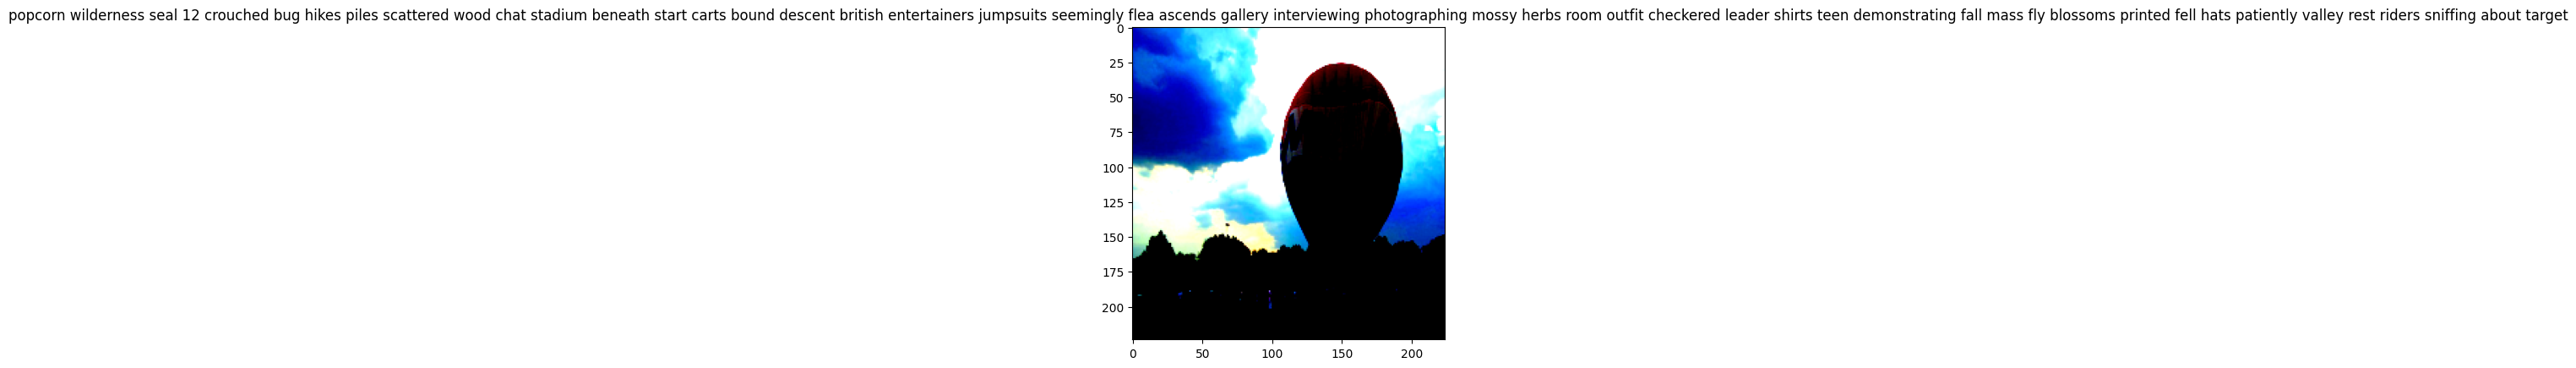

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


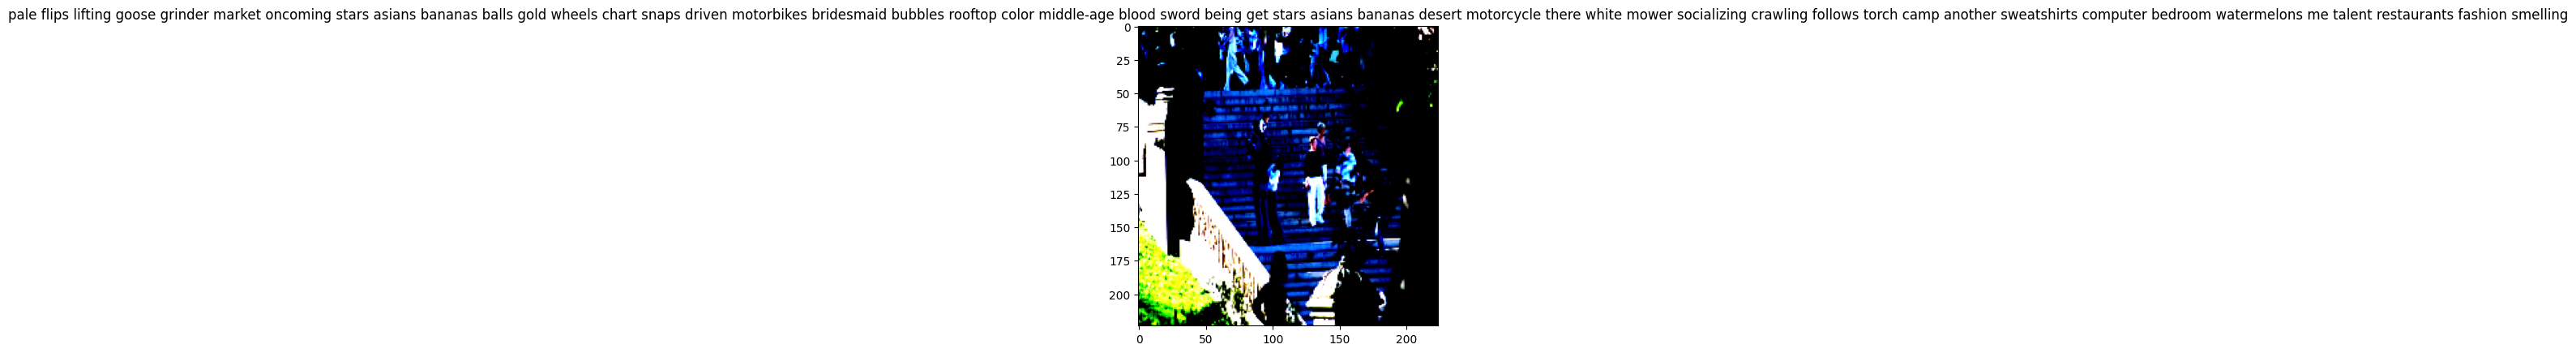

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


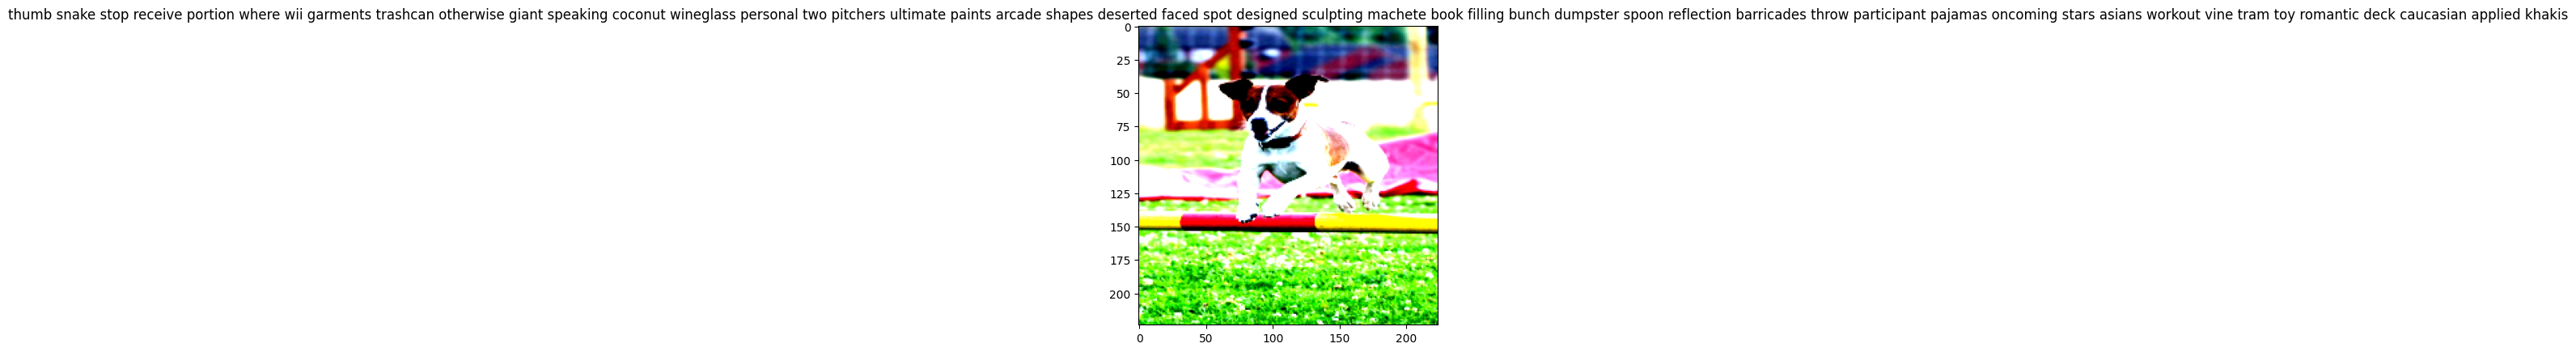

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


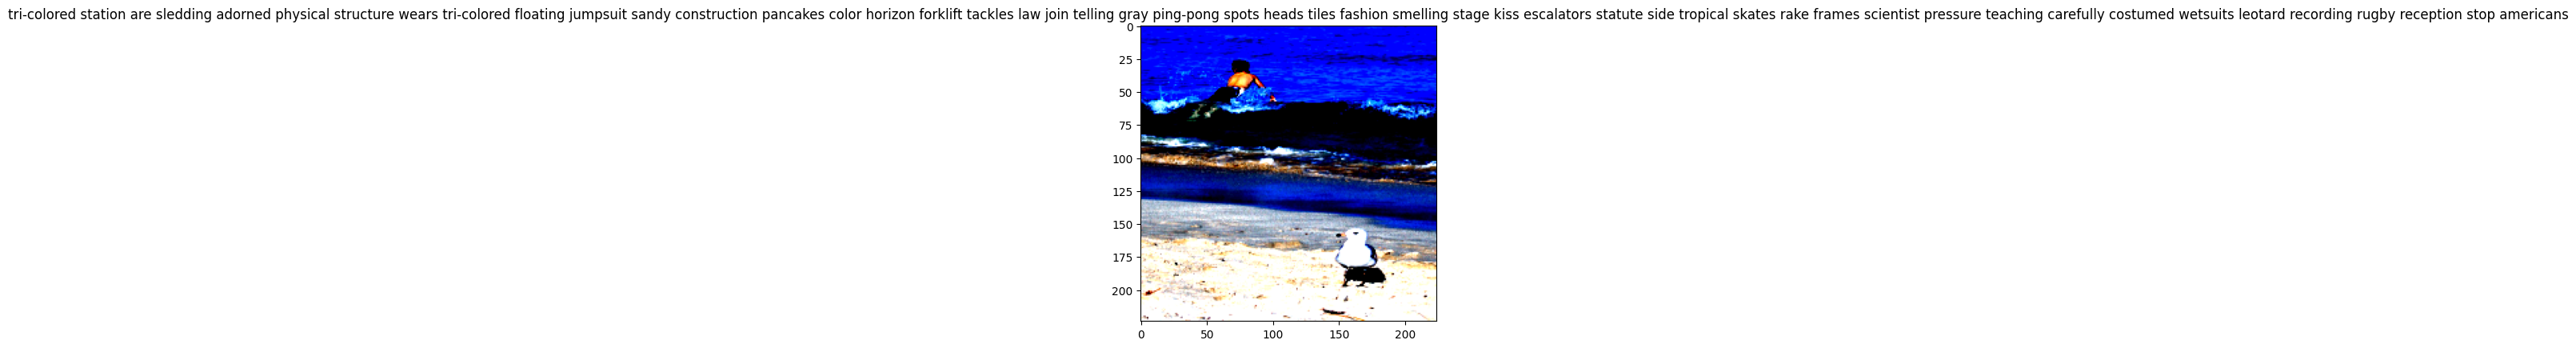

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


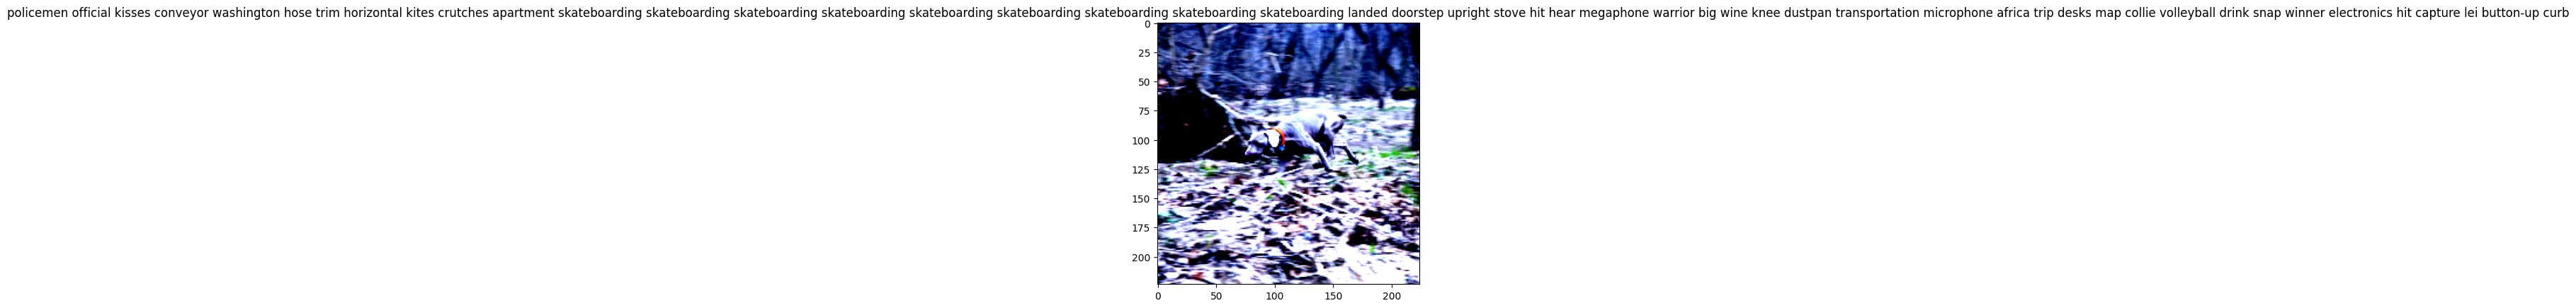

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


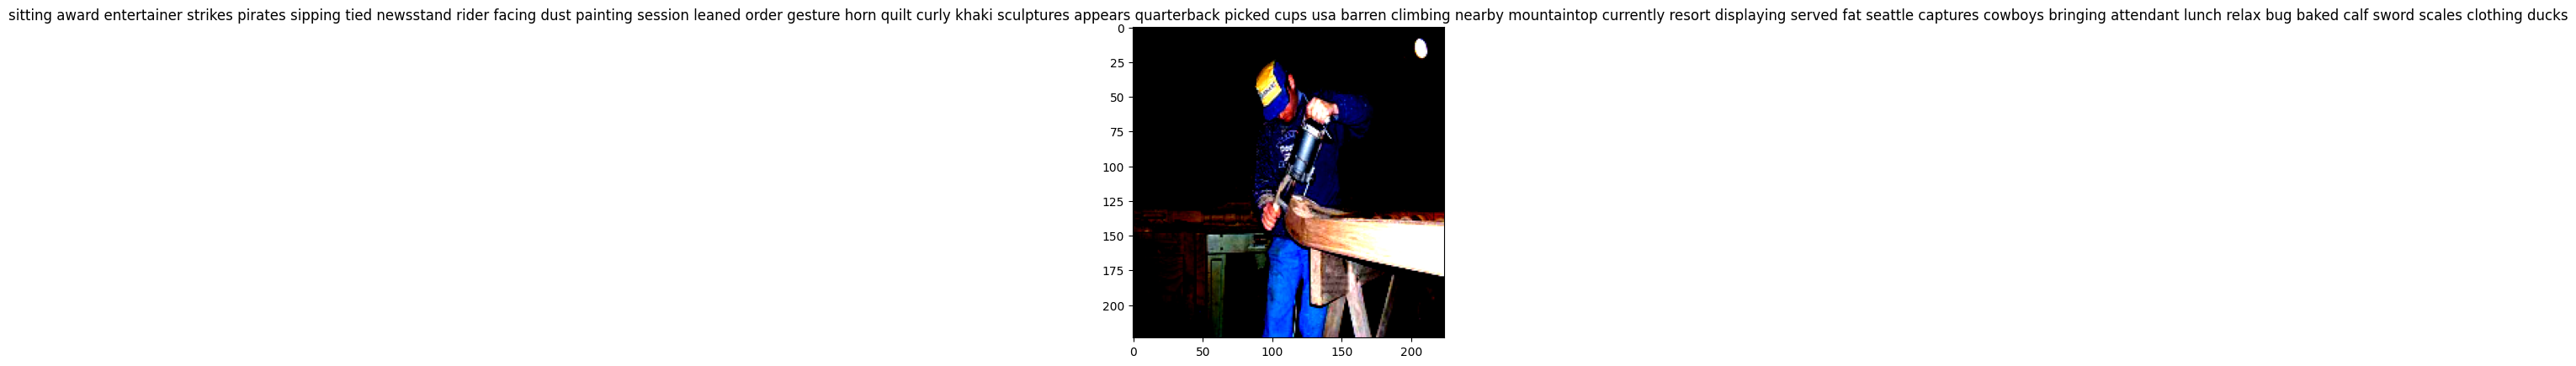

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


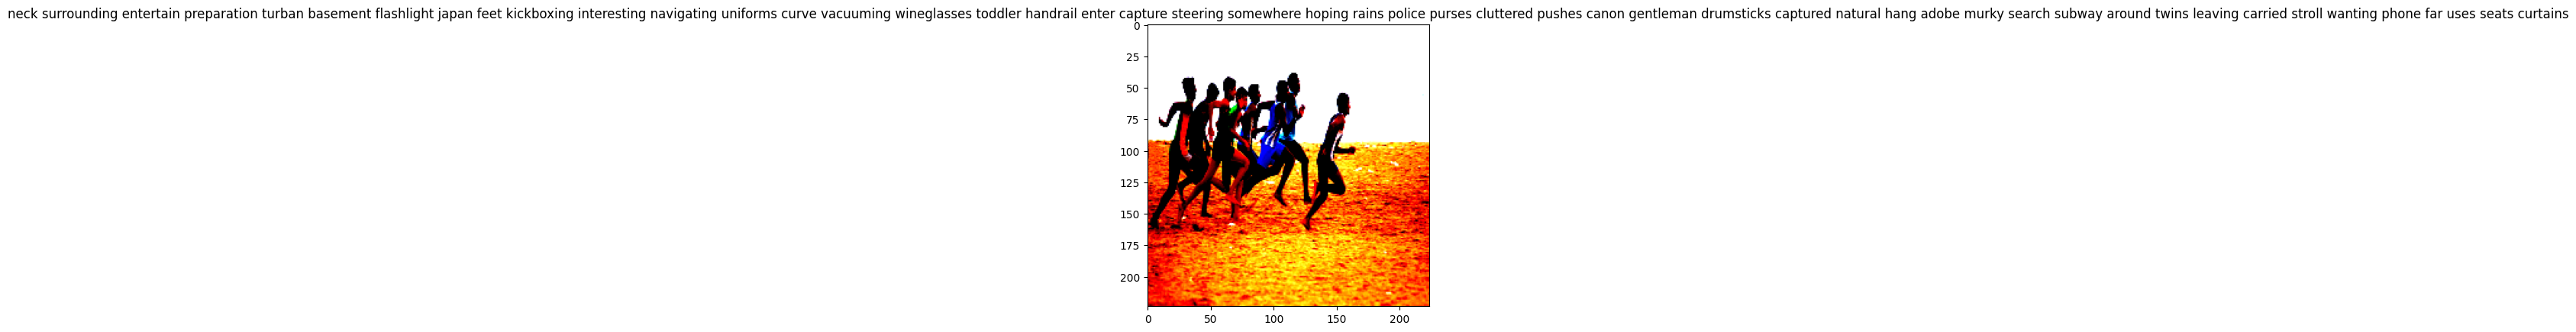

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


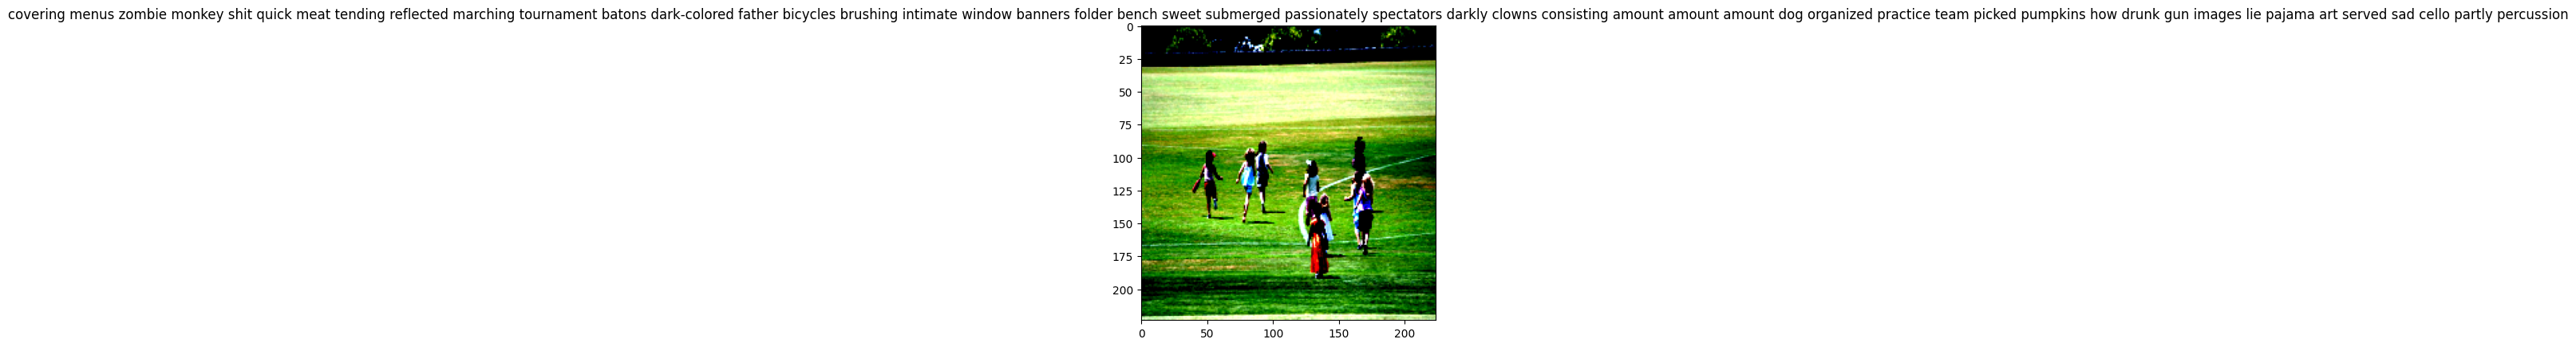

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


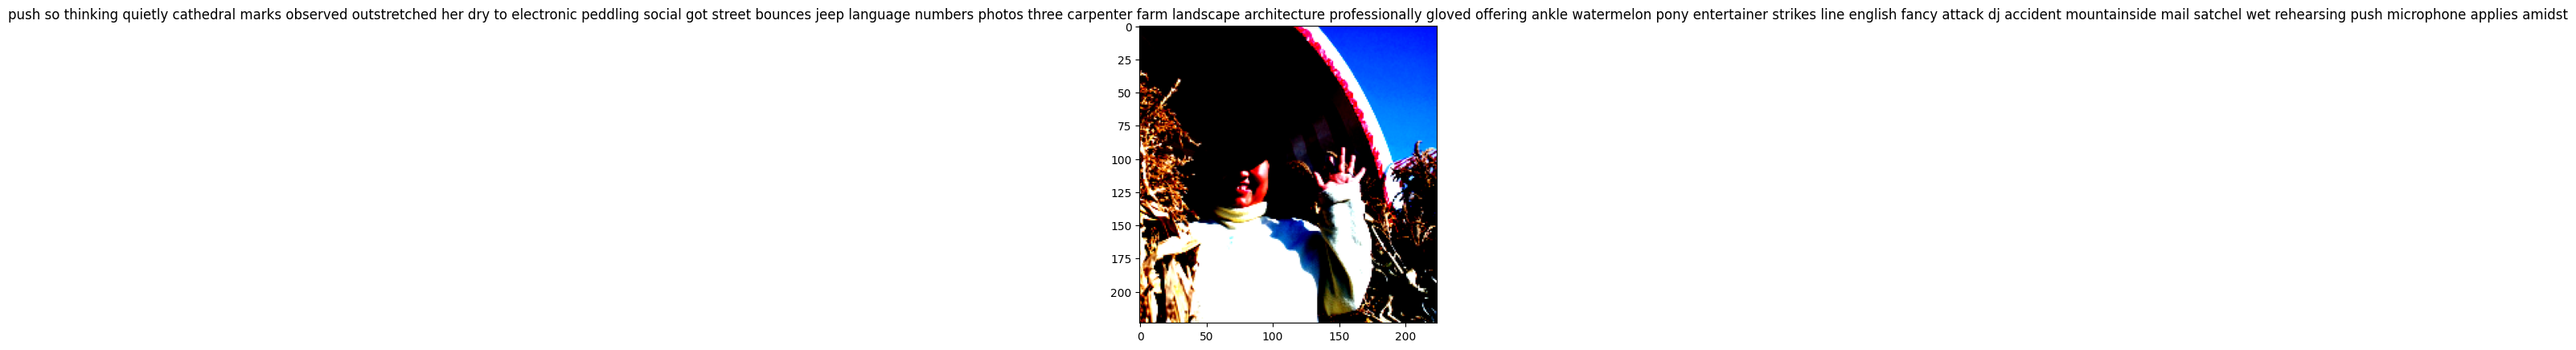

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


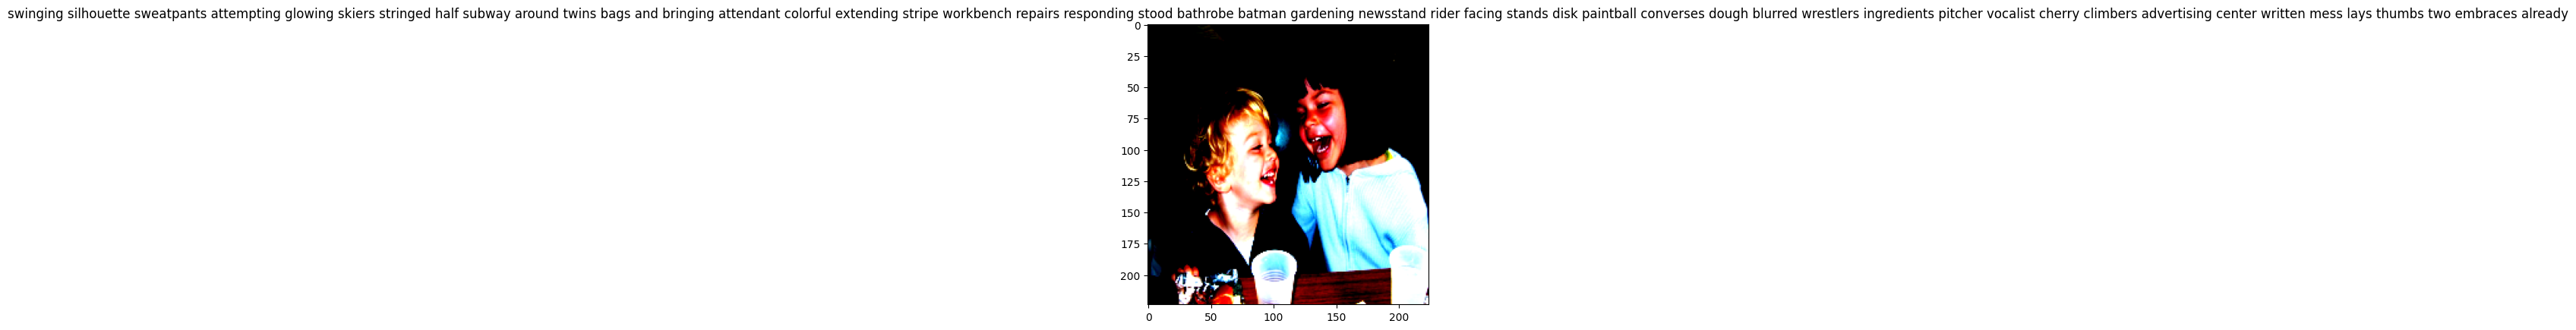

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


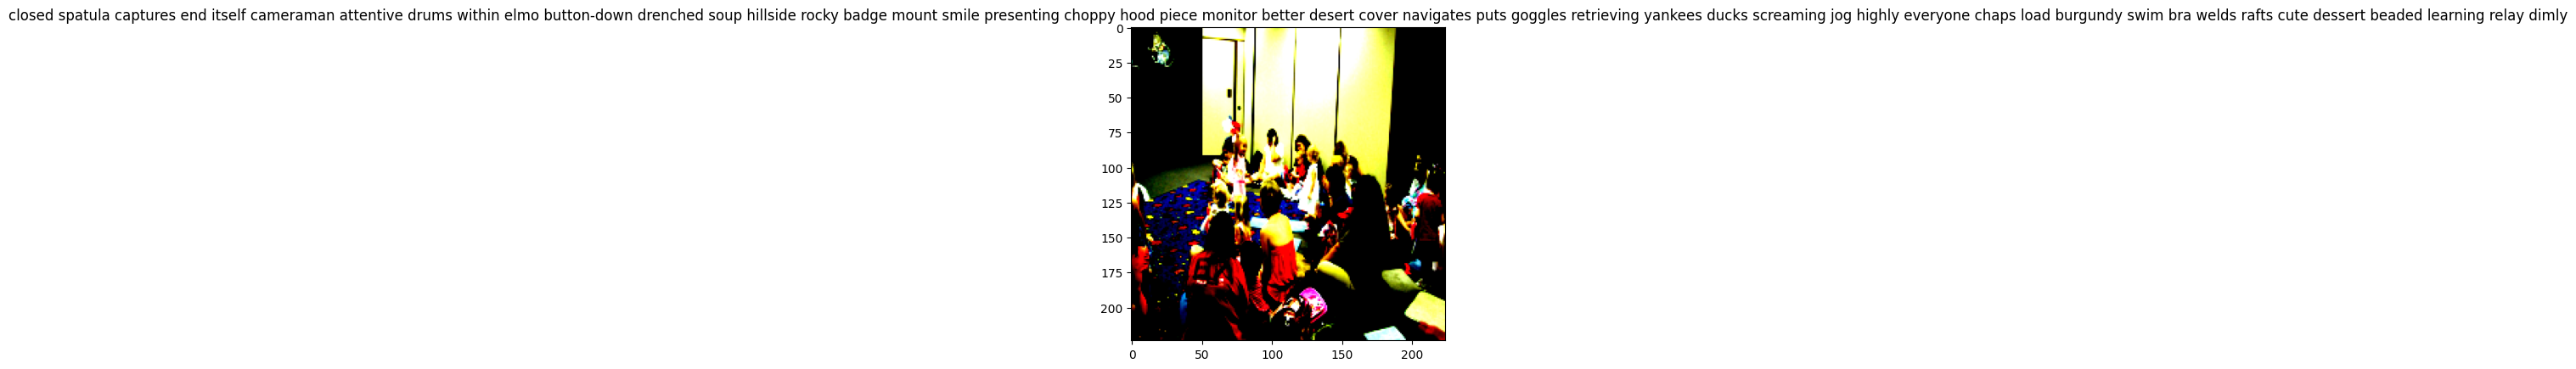

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


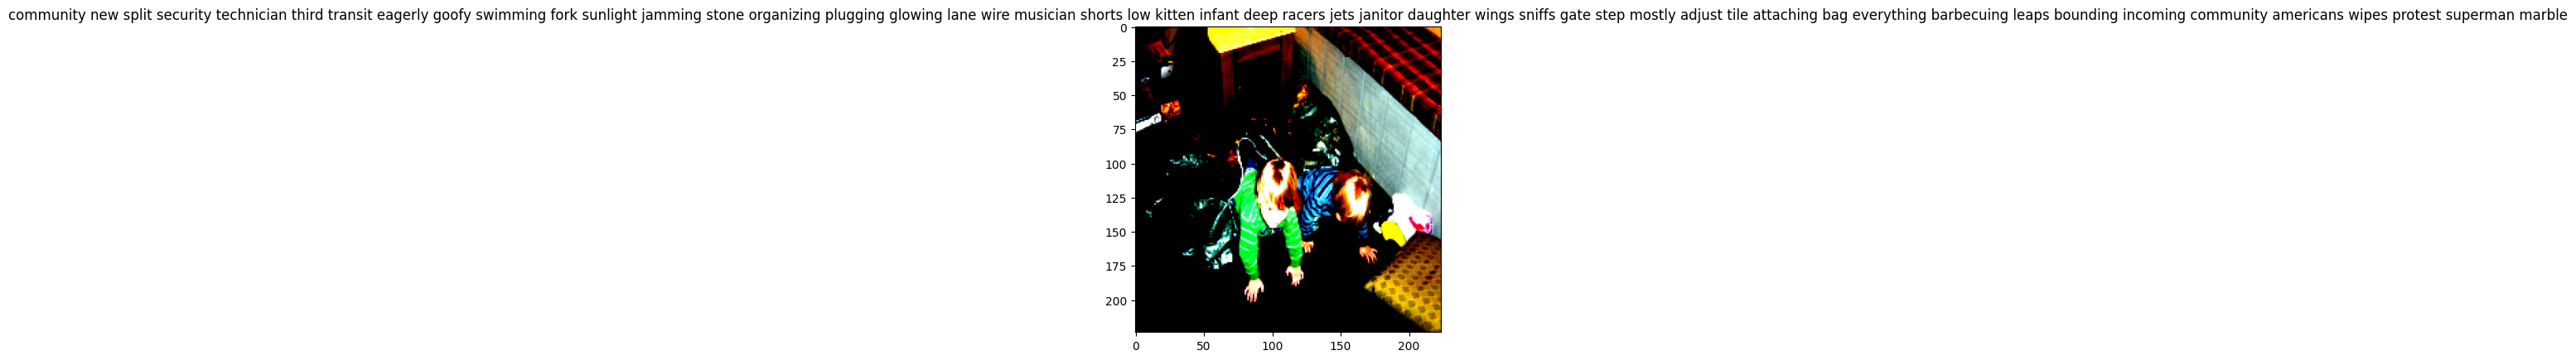

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


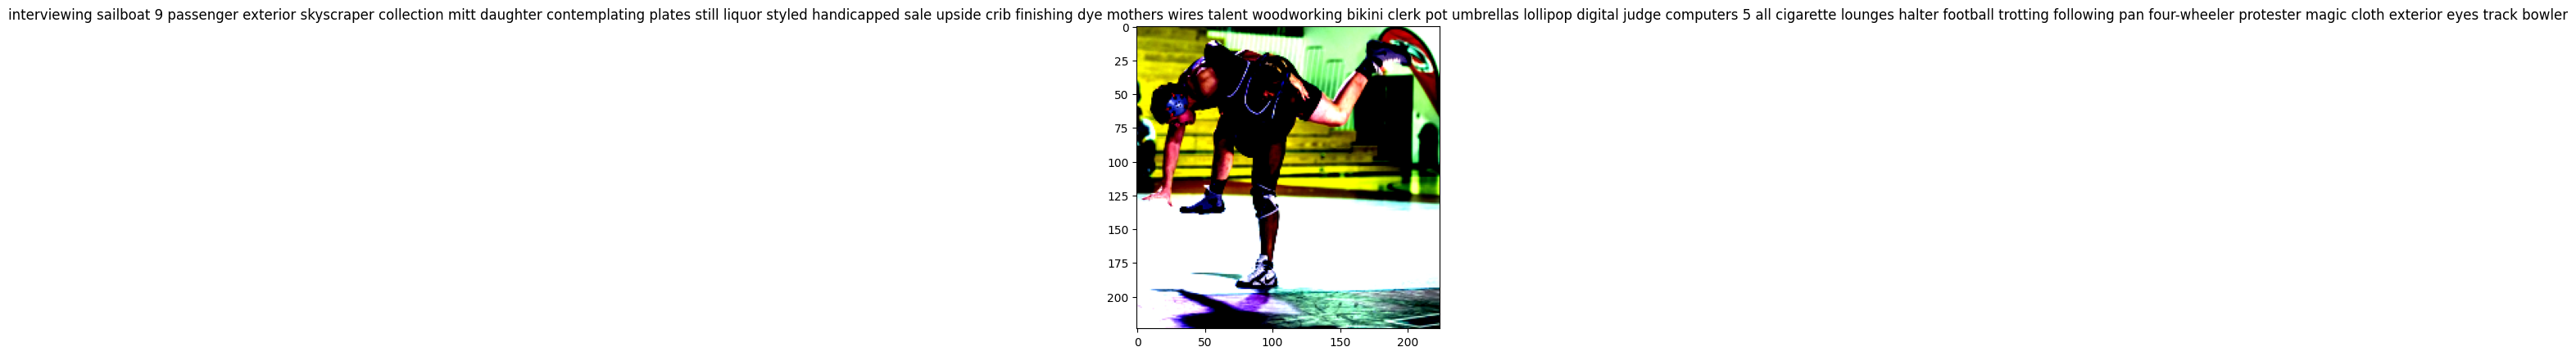

In [136]:
model.eval()

for batch in train_dl:
    (imgs, captions), captions_target = batch
    
    res = model(imgs, captions)
    print(res.shape)
    
    generated_captions_batch = model.simple_gen(imgs)
    for i, caption in enumerate(generated_captions_batch):
        fig, ax = plt.subplots()

        ax.imshow(imgs[i].permute(1, 2, 0))
        ax.set_title(caption)
        plt.show()
    
    break

## Training

In [137]:
# do not penalize padding tokens
criterion = nn.CrossEntropyLoss(ignore_index=vocab[Vocabulary.pad])

optimizer = optim.Adam(model.parameters(), lr=config['lr'])

In [138]:
def train_epoch(model, optimizer, data_loader: DataLoader):
    
    model.train()
    
    total_samples = len(data_loader.dataset)
    total_loss = 0
    
    for i, ((imgs, captions), captions_target) in enumerate(tqdm(data_loader, leave=False)):
        output = model(imgs, captions) #(batch_size, seq_size, vocab_size)
        
        output = output.permute(1, 0, 2) #(seq_size, batch_size, vocab_size)
        captions_target = captions_target.permute(1, 0) #(seq_size, batch_size)
        
        optimizer.zero_grad()
        losses = [criterion(output[seq_idx].to(dev), captions_target[seq_idx].to(dev)) for seq_idx in range(len(output))]
        loss = sum(losses)
        loss.backward()
        optimizer.step()
        
        loss_b = sum([l.item() for l in losses])
        print("Batch loss:", loss_b)
        total_loss += loss_b
        
    avg_loss = total_loss / total_samples
    print('Training loss: ' + '{:.4f}'.format(avg_loss))

for epoch in tqdm(range(config['epochs'])):
    train_epoch(model, optimizer, train_dl)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\attil\AppData\Local\Temp\ipykernel_26912\2919743234.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


Batch loss: 161.80967140197754
Batch loss: 269.6594076156616
Batch loss: 251.79684972763062
Batch loss: 168.52005815505981
Batch loss: 311.27565574645996
Batch loss: 195.93531894683838
Batch loss: 187.02539920806885
Batch loss: 184.35977125167847
Training loss: 13.9547


  0%|          | 0/8 [00:00<?, ?it/s]

Batch loss: 158.18698453903198
Batch loss: 266.5358943939209
Batch loss: 250.329083442688
Batch loss: 167.78206157684326
Batch loss: 303.78974962234497
Batch loss: 193.48979568481445
Batch loss: 183.35374927520752
Batch loss: 185.6433973312378
Training loss: 13.7832


C:\Users\attil\AppData\Local\Temp\ipykernel_26912\2919743234.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


torch.Size([16, 19, 5000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


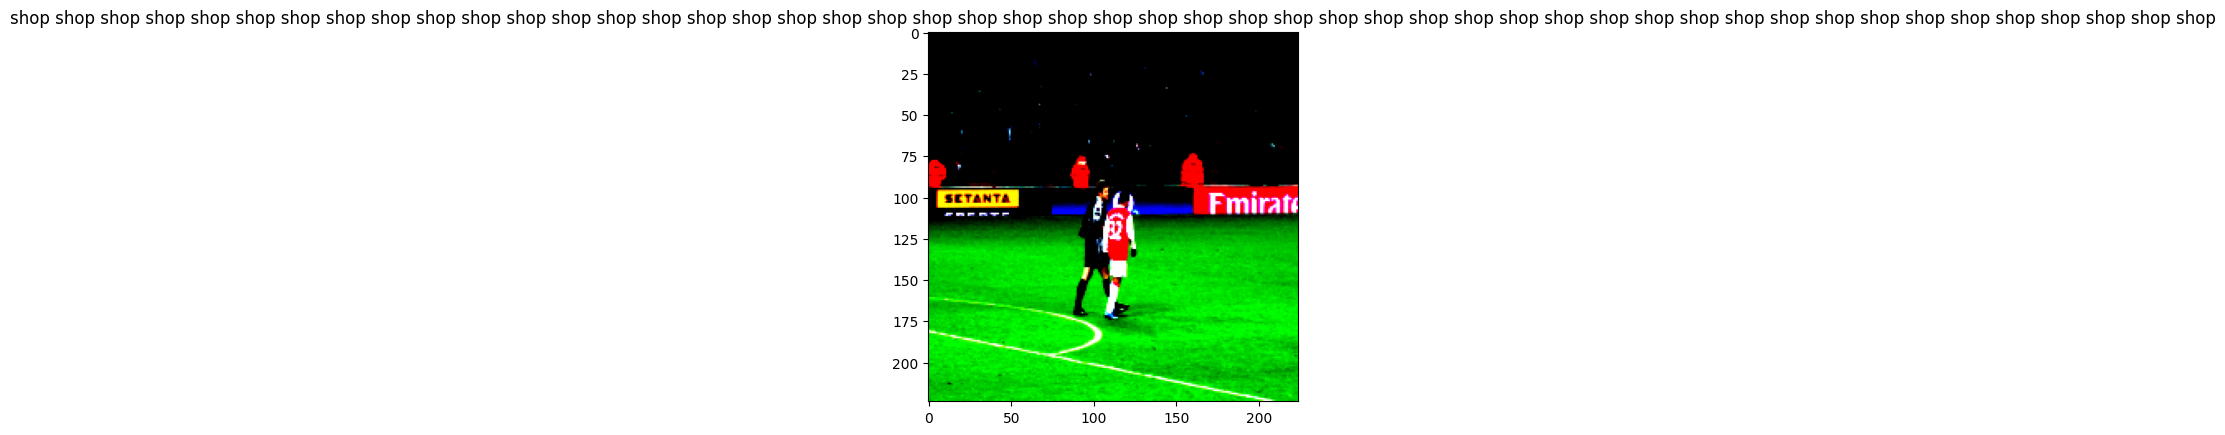

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


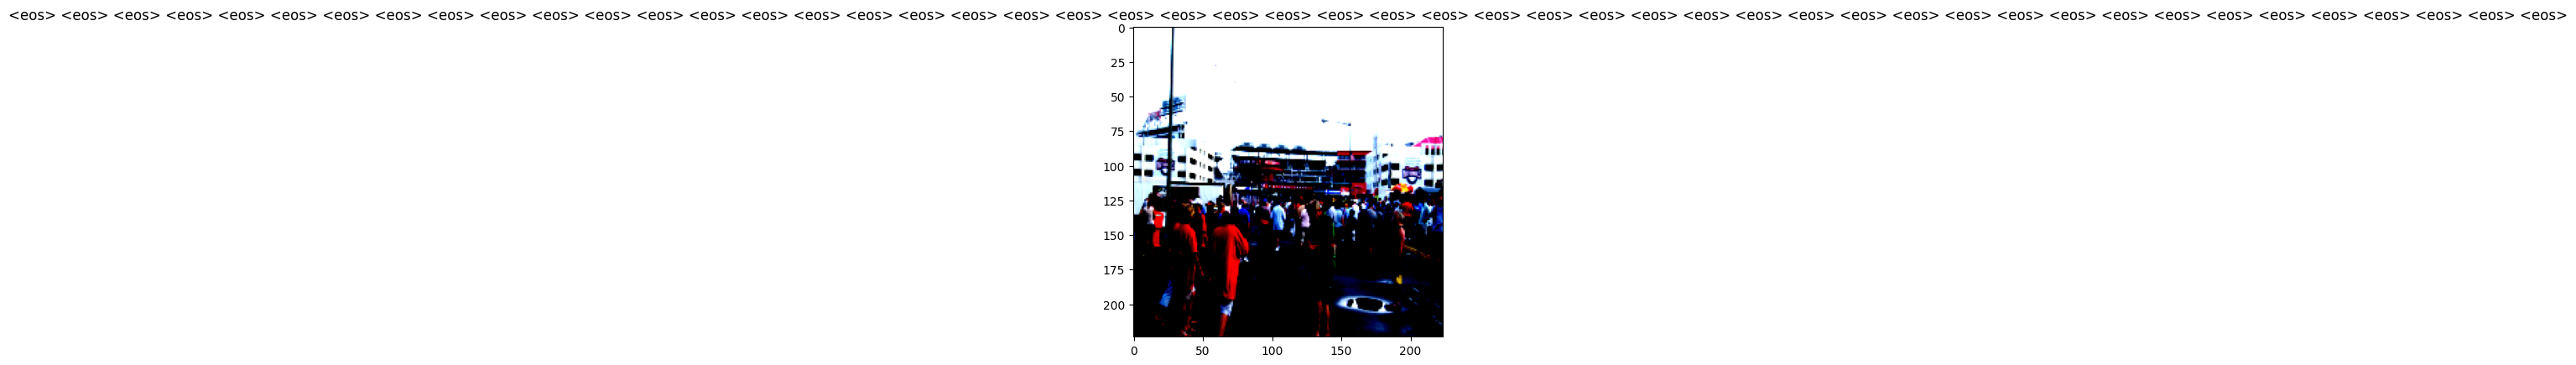

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


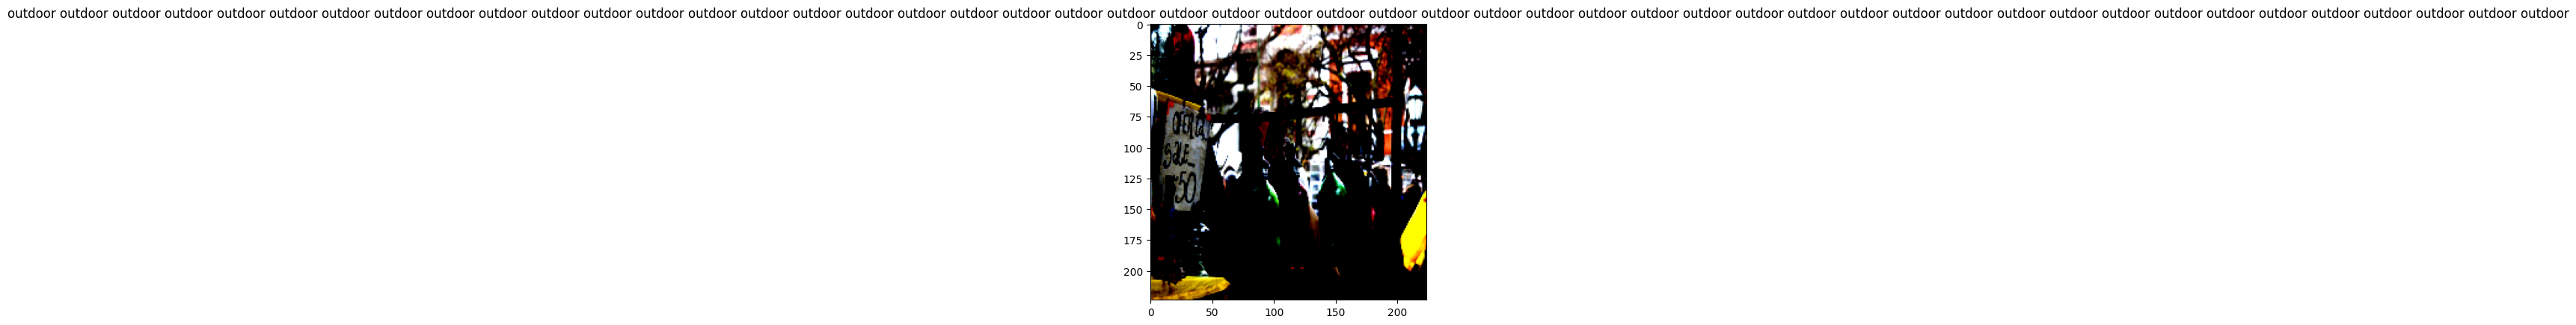

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


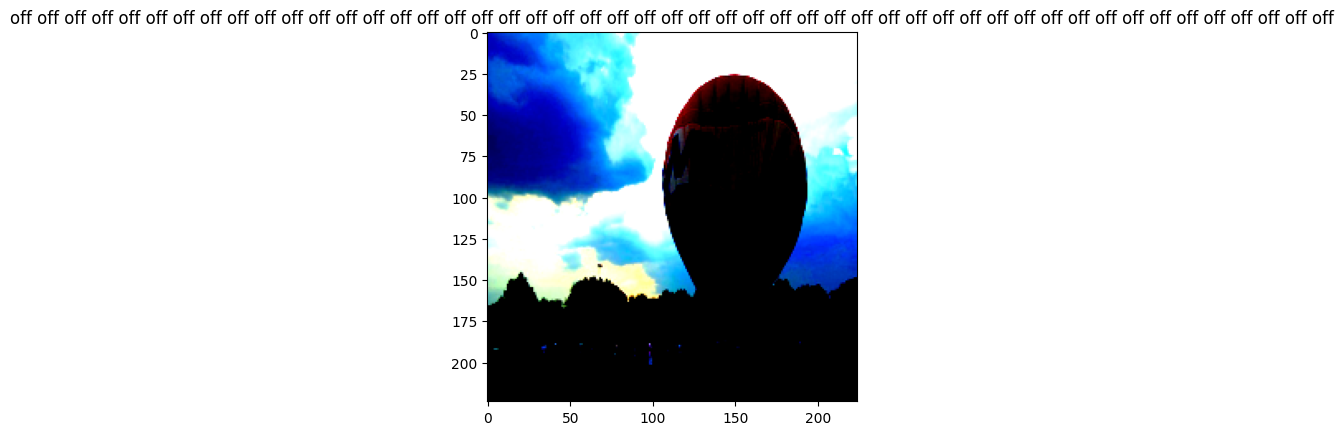

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


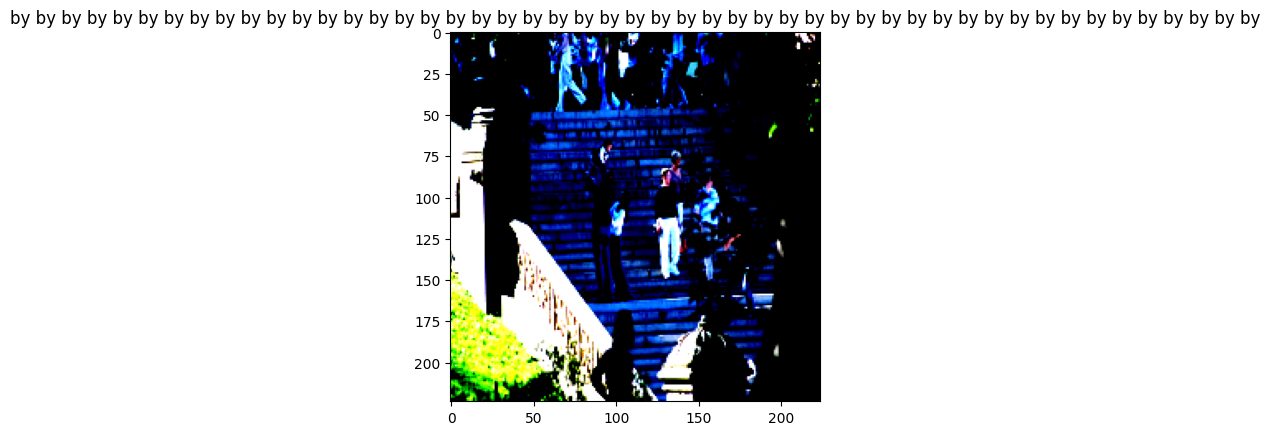

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


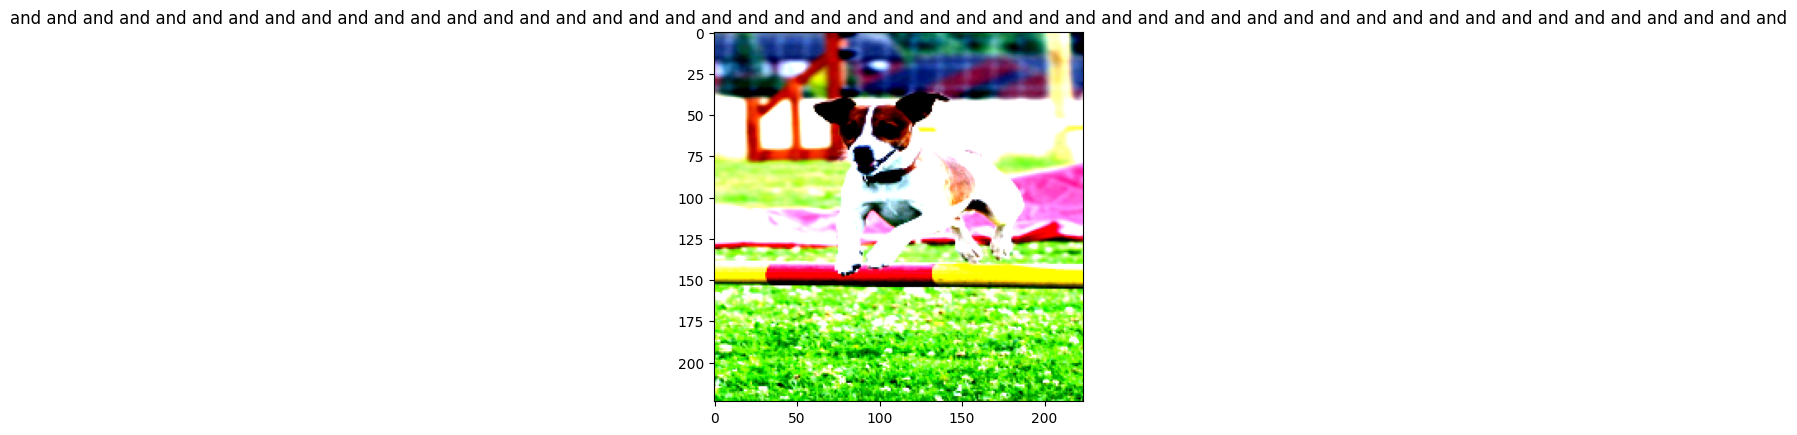

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


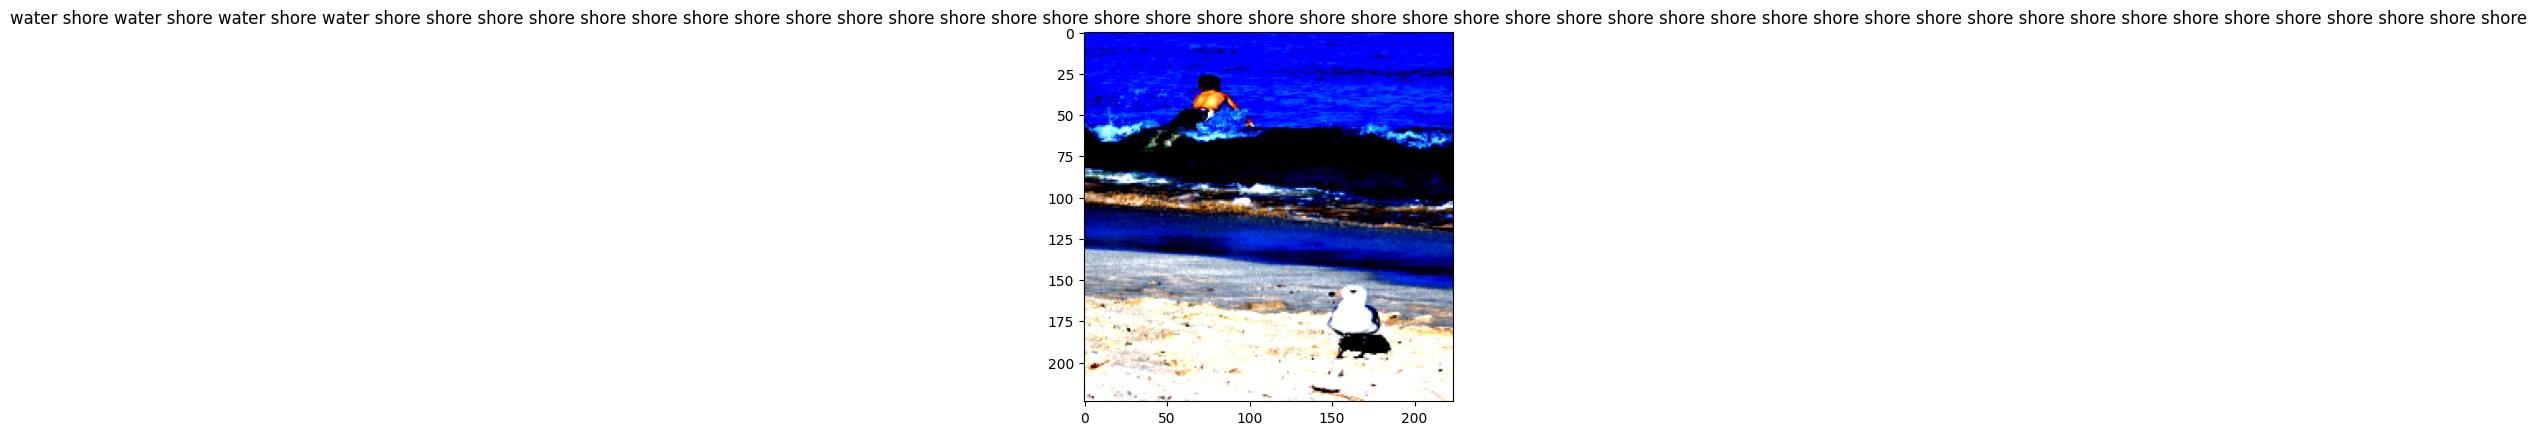

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


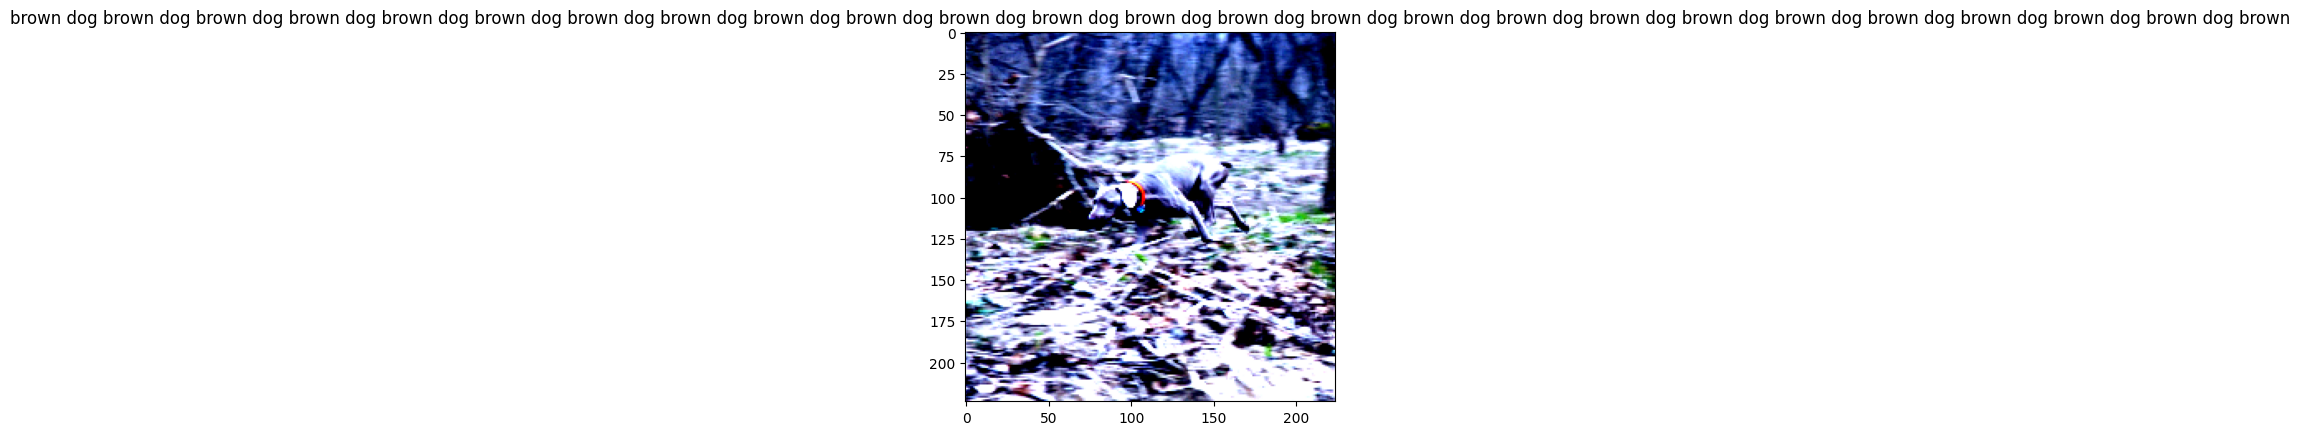

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


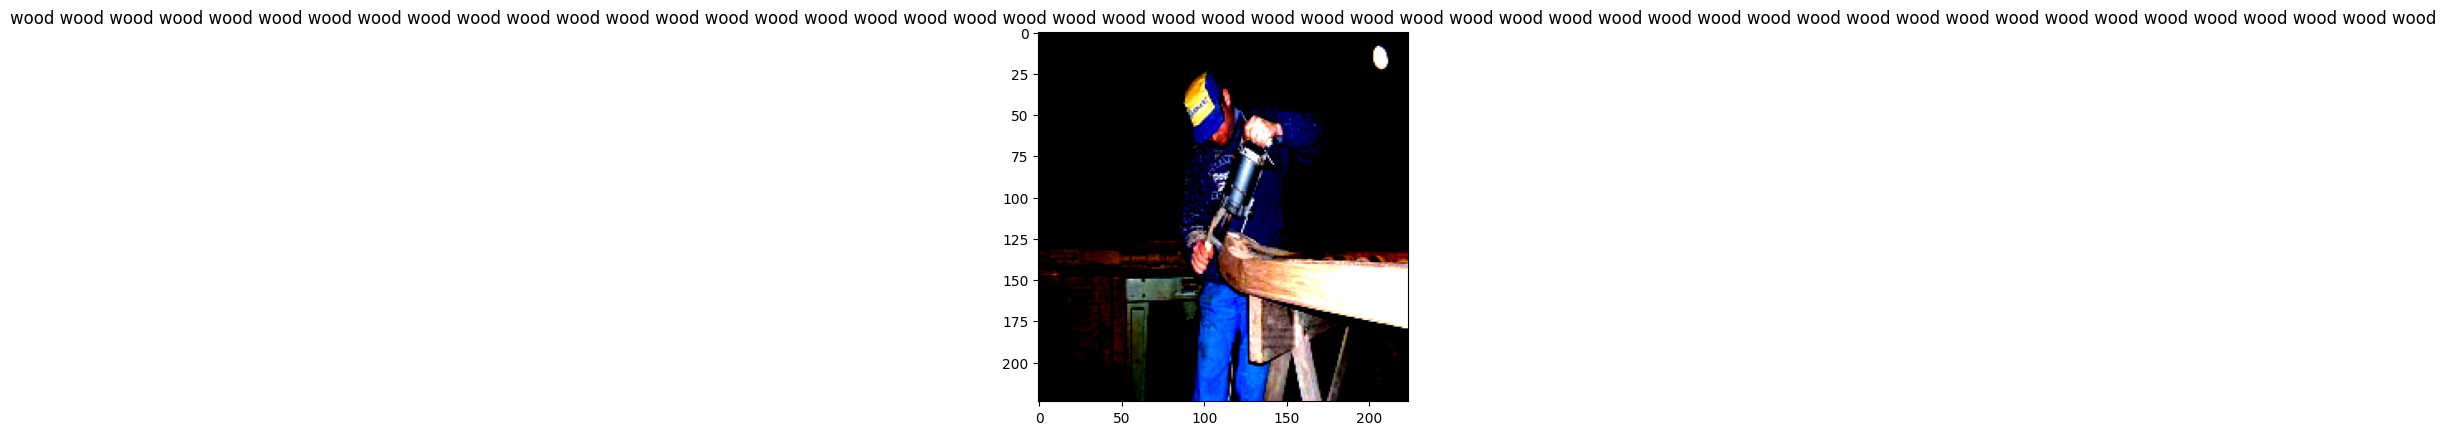

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


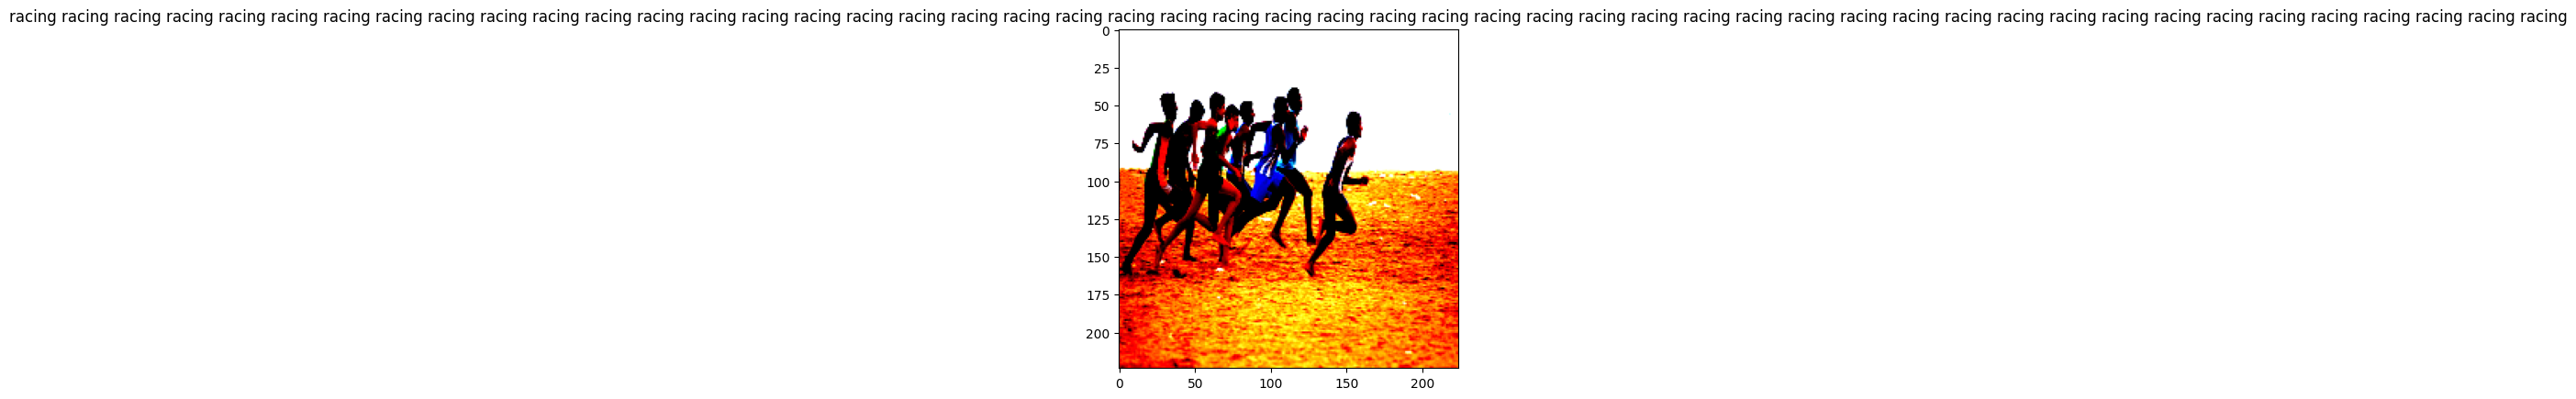

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


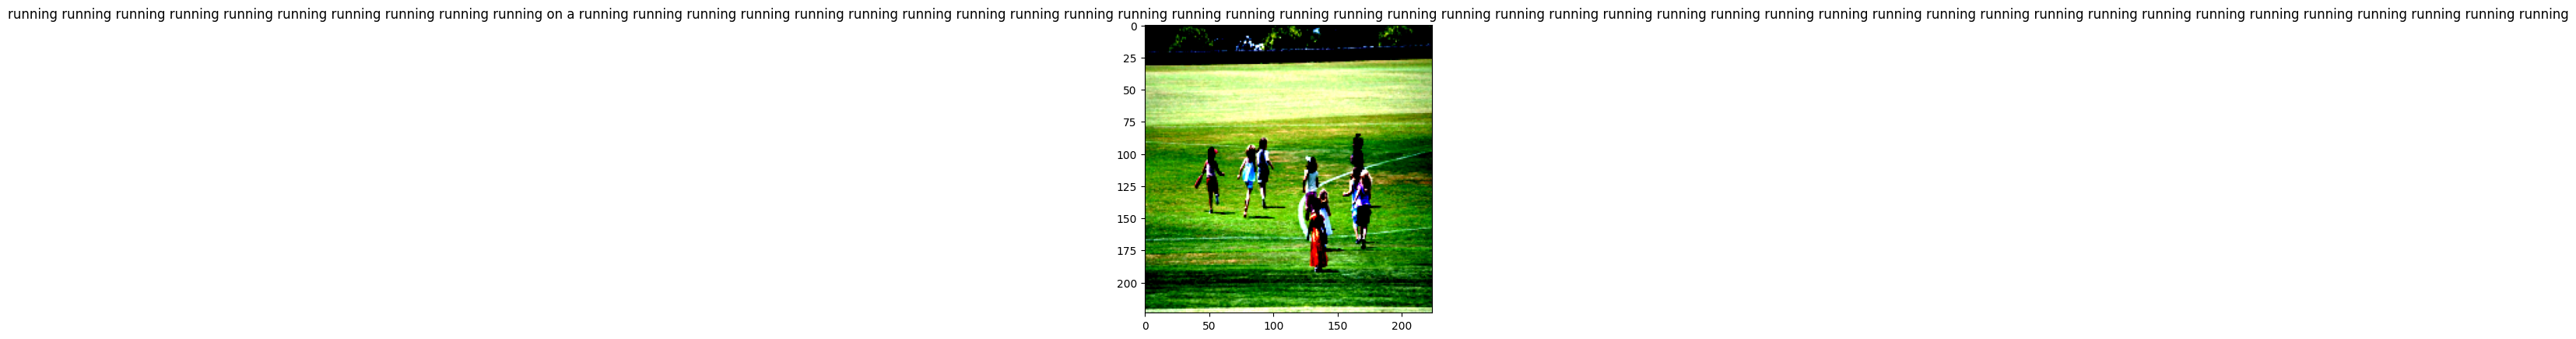

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


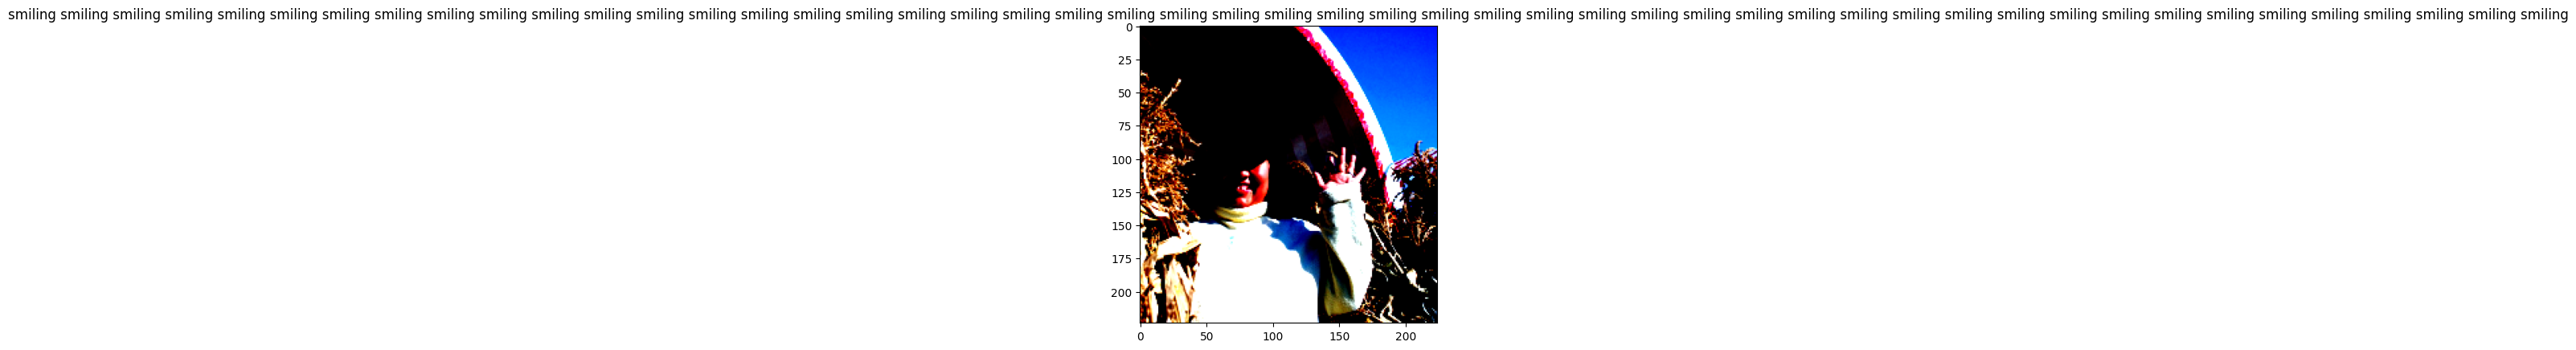

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


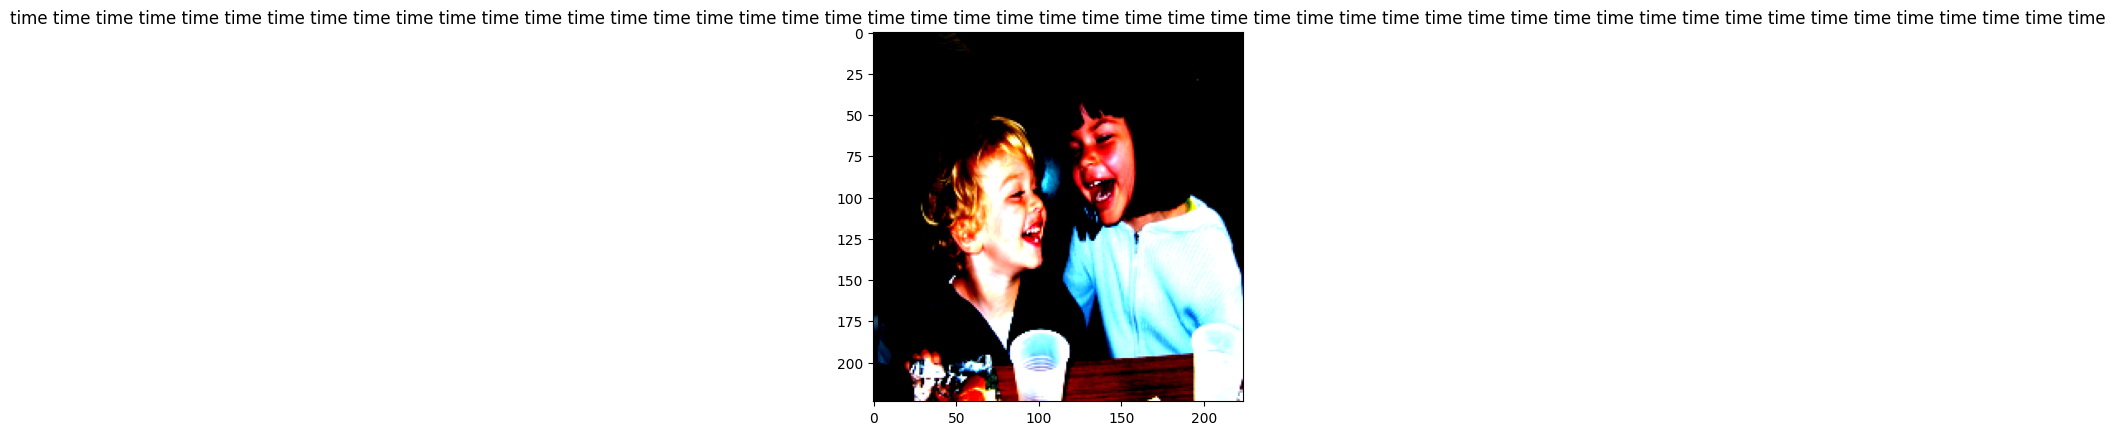

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


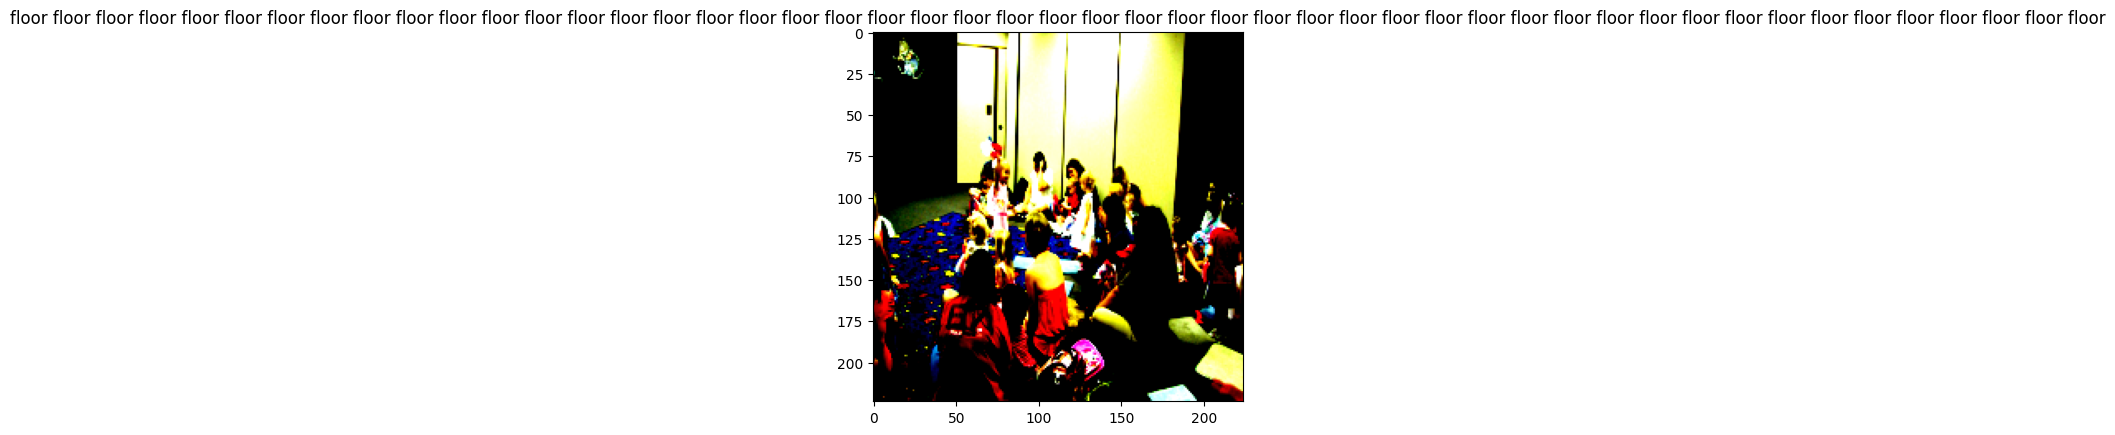

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


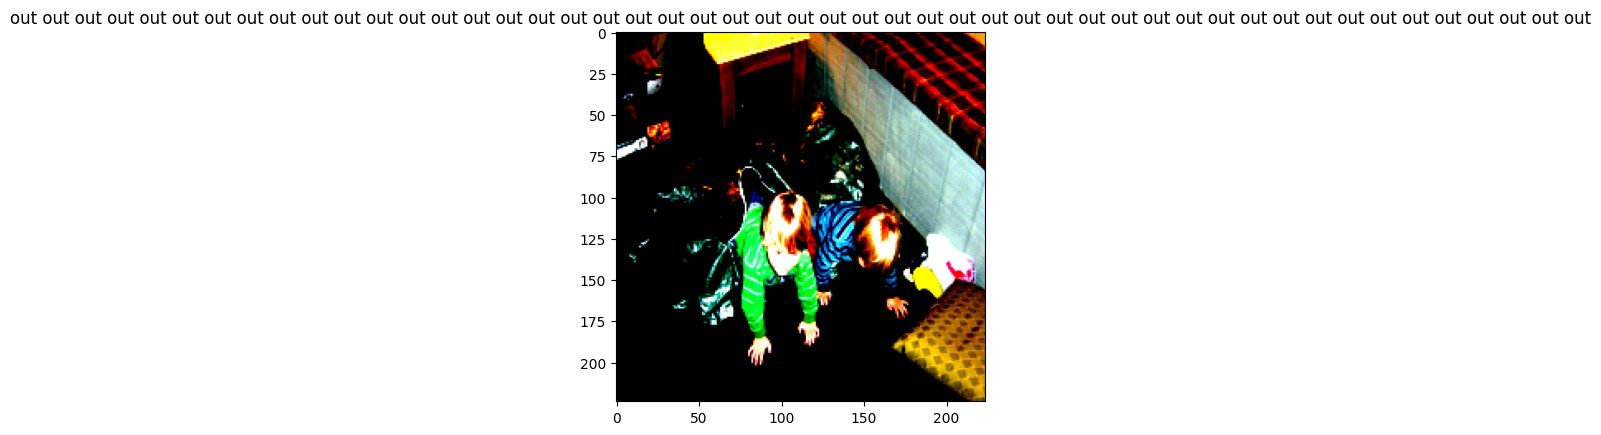

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


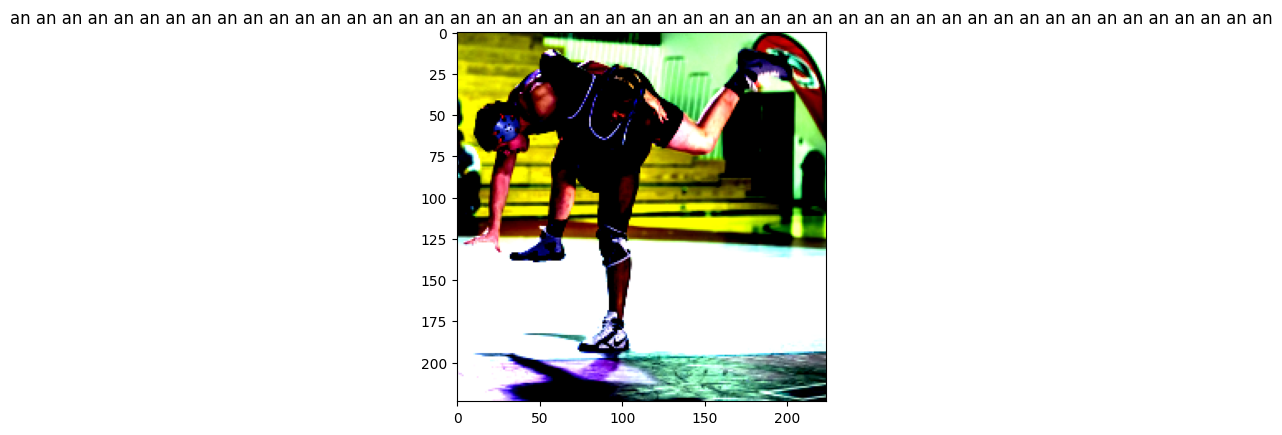

In [139]:
model.eval()

for batch in train_dl:
    (imgs, captions), captions_target = batch
    
    res = model(imgs, captions)
    print(res.shape)
    
    generated_captions_batch = model.simple_gen(imgs)
    
    for i, caption in enumerate(generated_captions_batch):
        fig, ax = plt.subplots()

        ax.imshow(imgs[i].permute(1, 2, 0))
        ax.set_title(caption)
        plt.show()
    
    break

Unfortunately, the training does not seem to converge and I was not able to identify the cause of the problem, despite the large amount of time and effort I put into it. Maybe this task was a bit too much for me, especially due to the language processing part.

## Possible solutions

 - Missing or wrong mask. 
   - This was the toughest part from me, to understand, how and where to use masks. 
   - Maybe there is a mask missing in the masked self-attention of the decoder block, although, as I have understood from the documentation, the parameter `is_causal=True` should do the masking.
   - Maybe setting the `key_padding_mask` parameter of the Decoder's Masked-MultiHeadAttention would help.
 - Longer training.
   - I did not let the training run too long due to the plateauing large losses of the initial epoch and because I strongly think, there is a bug in the code somewhere.
 - Adjusting the hyperparameters.
 - Using beam search.